In [1]:
import os
import importlib
from tqdm import tqdm
import pickle
import cv2
import glob

import preprocessing
importlib.reload(preprocessing)
from preprocessing import *

# CoastalWQL
This is the python notebook for the workflow process as follows:

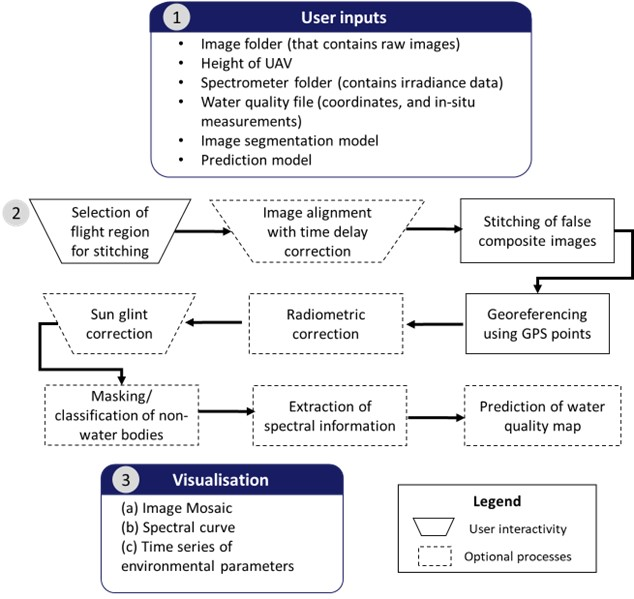

In [94]:
%matplotlib inline
from IPython.display import Image
Image('images/workflow.jpg')

## Inputs

- Raw Image Structure for *Bayspec's OCI-F*

![alt text](images/raw_image_structure.jpg "Raw Image Structure for Bayspec")

- Spectroradiometer data measuring irradiance data for *OceanOptics's Flame VIS-NIR*

![alt text](images/spectroradiometer.jpg "Spectroradiometer data")

- GPS data

![alt text](images/GPS_csv.png "GPS")

- GPS index of selected points

![alt text](images/GPS_selected_points.jpg "GPS index of selected points")

#### Required inputs

In [74]:
# image directory where raw images are stored
image_fp = "C:/Users/PAKHUIYING/Documents/image_processing/22_08_2021/10-55-00RES1280_EXP0100_GAN0030_BIT08_2EXP0056_GAN0010_RES1280_BIT08"

# spectroradiometer directory where irradiance data are stored
spectrometer_fp = "C:/Users/PAKHUIYING/Documents/image_processing/22_08_2021/08_22_2021"

# define a folder to store newly created files
fp_store = r"C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\NanyangLake_test"

# define a prefix for your file names, choose something that you will be able to understand later on
prefix = "NYL"

# flight height (in meters) from the ground surface (sometimes GPS altitude readings are not accurate)
height = 35
gsd = compute_ground_resolution(camera_height = height)
print(f'Ground resolution: {gsd}')

# GPS index of selected points
# if the coordinate selection is used in the GUI_platform, the gps_index_txt file will be automatically saved
# an example is provided in the *inputs* folder
gps_index_txt = r"inputs\gps_index_test_alignment.txt"

# checkboxes to conduct different pre-processing

# image segmentation to mask land/vessels
mask_checkbox = True
# de-striping of pushbroom hyperspectral images
noise_checkbox = True
# sun glint correction using SUGAR algorithm
sunglint_checkbox = True
# radiometric correction (requires spectroradiometer and irradiance data)
radiometric_checkbox = True
# turbidity prediction using Nechad's 2009 semi-analytical algorithm
predict_checkbox = True
# bands for creating the visual/rgb orthomosaic
r,g,b = 38,23,15

Ground resolution: (0.01159375, 0.231875, 11.872)


### Read GPS index

In [75]:
gps_indices = read_gps_index(gps_index_txt)
print(f'gps indices for selected GPS points: {gps_indices}')
# Alternatively, u can manually input the indices as a list, e.g.
# gps_indices = [15, 47, 63, 94, 111, 144, 159, 193, 206, 239, 254, 286, 302, 334, 349, 381, 396, 429, 446, 480, 495, 527]
# but note that it may affect the stitching quality if the GPS points selected are not well chosen (e.g. chosen arbitrarily)

gps indices for selected GPS points: [15, 47, 63, 94, 111, 144, 159, 193, 206, 239, 254, 286, 302, 334, 349, 381, 396, 429, 446, 480, 495, 527]


### Plot selected GPS

gps file path:C:/Users/PAKHUIYING/Documents/image_processing/22_08_2021/10-55-00RES1280_EXP0100_GAN0030_BIT08_2EXP0056_GAN0010_RES1280_BIT08/UAV/gps_10-56-2-217.csv


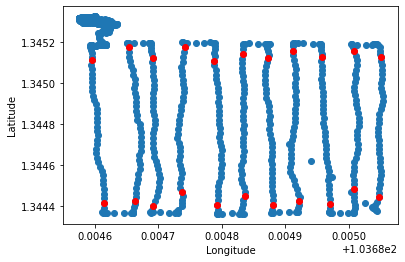

In [76]:
gps_df = import_gps(image_fp)
unique_gps_df = get_unique_df(gps_df)
plot_GPS(unique_gps_df,gps_indices)

### Get image indices from GPS indices

In [77]:
# account for flipping of images when imaging direction is reversed
reverse_boolean_list = rev_boolean_list(unique_gps_df,gps_indices)

# Nap GPS indices to image indices
indexes_list = gps_to_image_indices(unique_gps_df,image_fp,gps_indices, millisecond_delay = 0)
print(f'Image indices: {indexes_list}')

# number of flight lines
line_start = 0
line_stop = len(indexes_list)
print(f'Start line: {line_start}, Stop line: {line_stop}')


Image indices: [(718, 2278), (3064, 4578), (5406, 7014), (7752, 9415), (10055, 11664), (12397, 13961), (14737, 16290), (17022, 18588), (19314, 20925), (21747, 23407), (24133, 25697)]
Start line: 0, Stop line: 11


## Image Alignment (optional)

In [78]:
extended_rgb = ExtendedRGB(image_fp,gps_indices,height, unique_gps_df)
general_dict,datetime_list = extended_rgb.main()

corrected_img_start_index: 500, corrected_img_stop_index:8300
Before correction shape:(1024, 8320, 3)
After correction shape:(1024, 7801, 3)
corrected_img_start_index: 20, corrected_img_stop_index:7590
Before correction shape:(1024, 8100, 3)
After correction shape:(1024, 7571, 3)
corrected_img_start_index: 520, corrected_img_stop_index:8555
Before correction shape:(1024, 8575, 3)
After correction shape:(1024, 8036, 3)
corrected_img_start_index: 20, corrected_img_stop_index:8330
Before correction shape:(1024, 8830, 3)
After correction shape:(1024, 8311, 3)
corrected_img_start_index: 515, corrected_img_stop_index:8555
Before correction shape:(1024, 8575, 3)
After correction shape:(1024, 8041, 3)
corrected_img_start_index: 20, corrected_img_stop_index:7840
Before correction shape:(1024, 8350, 3)
After correction shape:(1024, 7821, 3)
corrected_img_start_index: 500, corrected_img_stop_index:8265
Before correction shape:(1024, 8285, 3)
After correction shape:(1024, 7766, 3)
corrected_img_st

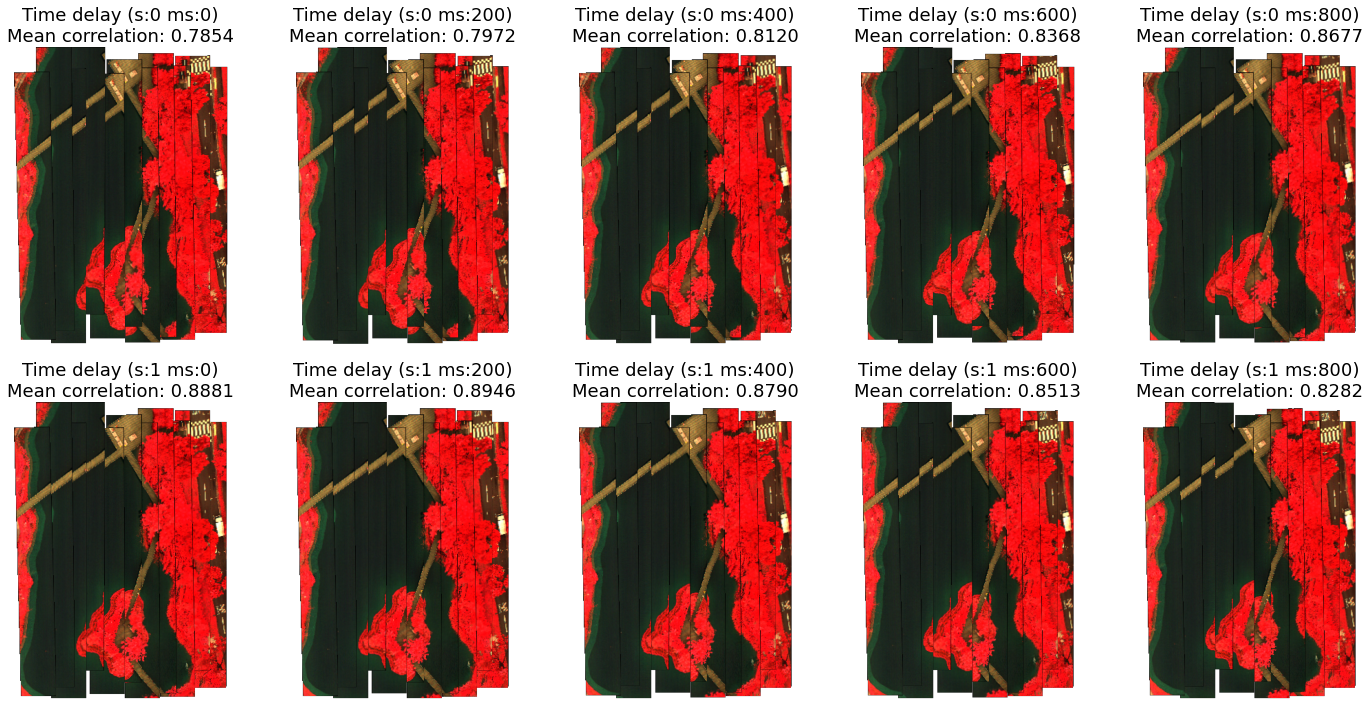

In [79]:
time_corrections = list(range(0,2000,200))
fig,axes = plt.subplots(2,ceil(len(time_corrections)/2),figsize=(20,10))

for i,(t,ax) in enumerate(zip(time_corrections,axes.flatten())):
    s,ms = divmod(t,1000)
    live_correction = LiveCorrection(general_dict,datetime_list,time_delay=t,scale=20)
    img_resize_list, correction_bytes_list,bckgrnd_attr,bbox_list = live_correction.main()
    corr_coeff_list,_ = calculate_correlation_overlap(img_resize_list)
    corr_coeff_avg = np.nanmean(corr_coeff_list)
    for arr in img_resize_list:
        ax.imshow(arr)
    ax.set_title('Time delay (s:{} ms:{})\nMean correlation: {:.4f}'.format(s,ms,corr_coeff_avg),fontdict={'fontsize':18})
    ax.set_axis_off()

# plt.rc('axes',titlesize = 15)
plt.tight_layout()
plt.show()

In [80]:
# # select the most appropriate time delay correction e.g.1200
live_correction = LiveCorrection(general_dict,datetime_list,time_delay=1200,scale=20)
# select the directory where you want to save the corrected_indices
live_correction.main()
live_correction.save_corrected_indices(fp_store)

# load the saved corrected_indices
corrected_fp = join(fp_store,"corrected_indices.json")
try:
    with open(corrected_fp, "r") as read_file:
        corrected_indices = json.load(read_file)
    corrected_indices = [(i['start'],i['stop']) for i in corrected_indices]
except:
    corrected_indices = None

print(f'corrected indices: {corrected_indices}')

# update indexes_list based on the alignment
if corrected_indices is not None:
    indexes_list = corrected_indices

corrected_img_start_index: 225, corrected_img_stop_index:7990
Before correction shape:(1024, 8320, 3)
After correction shape:(1024, 7766, 3)
corrected_img_start_index: 305, corrected_img_stop_index:7890
Before correction shape:(1024, 8100, 3)
After correction shape:(1024, 7586, 3)
corrected_img_start_index: 220, corrected_img_stop_index:8265
Before correction shape:(1024, 8575, 3)
After correction shape:(1024, 8046, 3)
corrected_img_start_index: 310, corrected_img_stop_index:8620
Before correction shape:(1024, 8830, 3)
After correction shape:(1024, 8311, 3)
corrected_img_start_index: 220, corrected_img_stop_index:8255
Before correction shape:(1024, 8575, 3)
After correction shape:(1024, 8036, 3)
corrected_img_start_index: 315, corrected_img_stop_index:8130
Before correction shape:(1024, 8350, 3)
After correction shape:(1024, 7816, 3)
corrected_img_start_index: 215, corrected_img_stop_index:7970
Before correction shape:(1024, 8285, 3)
After correction shape:(1024, 7756, 3)
corrected_img

# Extract spectral and in-situ data

#### WQL inputs (optional)

In [81]:
try:
    wql_csv = r"inputs\wql.csv"
    tss_df = pd.read_csv(wql_csv,engine='python')
    tss_df = tss_df[tss_df['SITE']=='ny2']
    tss_lat = tss_df.iloc[:,4].tolist()
    tss_lon = tss_df.iloc[:,5].tolist()
    tss_measurements = tss_df.iloc[:,-2].tolist()
    
    print(f'WQL column names: {tss_df.columns.to_list()}')
    print(tss_lat[:5])
    print(tss_lon[:5])
    print(tss_measurements[:5])
except:
    tss_lat = tss_lon = tss_measurements = wql_csv = None
    print("No WQL file found")


WQL column names: ['DATE', 'TIME', 'SITE', 'DATA ID', 'GPS Latitude (°)', 'GPS Longitude (°)', 'Barometer (mmHg)', 'Cond (µS/cm)', 'Sp Cond (µS/cm)', 'Sal (psu)', 'nLFCond (µS/cm)', 'TDS (mg/L)', 'Temp (°F)', 'Resistivity (ohms-cm)', 'Sigma-T (s t)', 'Sigma (s)', 'Turbidity (FNU)', 'TSS (mg/L)']
[1.3446799999999999, 1.3446799999999999, 1.3446799999999999, 1.3446799999999999, 1.3446799999999999]
[103.68465, 103.68465, 103.68465, 103.68465, 103.68465]
[10.89, 6.2, 2.23, 2.19, 2.17]


### Image segmentation inputs (optional)
- A trained XGBoost model is used to perform the image segmentation, where an assigned value of `2 = caisson/land`, `1 = vessels/boat`, `0 = water`

In [82]:
xgb_seg_fp = r"Models\image_segmentation\xgb_segmentation.json"
xgb_seg_model = load_xgb_segmentation_model(xgb_seg_fp)

### Sun glint correction inputs (optional)
- One can use Hedley's sun glint correction algorithm, but one must supply the bounding box (bbox) over a region in the imagery where there are sun glint pixels in a deep water (where water-leaving NIR over deep water can be assumed to be negligible, however, over extremely turbid regions or shallow regions, water-leaving NIR *cannot* be assumed to be negligible). (See `sunglint_correction/Hedley.py`)
- Therefore, the SUGAR correction is an algorithm where sun glint correction is solely focused on sun glint affected regions, while keeping other scenes unaltered. No ancillary data is required for SUGAR (See `sunglint_correction/SUGAR.py`) [DEFAULT]
- More details on the comparisons of different sun glint correction can be found in `sunglint_correction.ipynb`

#### Prediction inputs (optional)
- One can input your own trained machine learning model, provided that one also provides the index of the bands that are involved in the prediction
- otherwise one can also use Nechad's (2009) semi-analytical algorithm:

$$ Turbidity [FNU] = \frac{A_\tau R_T(\lambda_{Red})}{1-R_T(\lambda_{Red})/C} $$

where $A_\tau$ and $C$ are wavelength dependent calibration coefficients to be optimised using the least squares method. It is recommended to optimise these coefficients based on your in-situ measurements as ranges of turbidity may be different across sites. We will be using $A_\tau = 87.75$ and $C=0.2324$. $R_T(\lambda_{Red}) = $ reflectance at band 660nm

- One can import their machine model and indicate the covariates (i.e. bands) that is used for turbidity retrieval (see API: `StitchHyperspectral.get_predicted_image(...)`)
- Or prediction using Nechad's (2010) (see API: `StitchHyperspectral.get_nechad_predicted_image(...)`)

# Process images

### Save user-options

In [85]:
config_file = {'-PROCESSED_IMAGES-':fp_store,'-PREFIX-':prefix,'-IMAGE_FOLDER_FILEPATH-':image_fp,\
                '-SPECTRO_FILEPATH-':spectrometer_fp,\
                '-HEIGHT-':height,'-GPS_INDEX_TXT-':gps_index_txt,\
                '-LINE_START-':line_start,'-LINE_END-':line_stop,'rgb_bands':[r,g,b],\
                '-MASK_CHECKBOX-':mask_checkbox,\
                '-RADIOMETRIC_CHECKBOX-':radiometric_checkbox,'-NOISE_CHECKBOX-':noise_checkbox,\
                '-SUNGLINT_CHECKBOX-':sunglint_checkbox,'-PREDICT_CHECKBOX-':predict_checkbox,\
                'corrected_indices':corrected_indices}

# if config_file['-PREDICT_CHECKBOX-'] == True:
#     prediction_parameters = {'-MODEL_PREDICTORS-':covariates_index_list,'-DOWNSAMPLE_SLIDER-':downsample_slider,'-MODEL_FILEPATH-':model_fp,'model_type':model_type}
#     for k,v in prediction_parameters.items():
#         config_file[k] = v

if wql_csv is not None:
    config_file['-WQL_CSV-'] = wql_csv
    
with open(join(fp_store,'config_file_{}.txt'.format(config_file['-PREFIX-'])),'w') as cf:
    json.dump(config_file,cf)

### Batch process all flight lines

In [86]:
for line_number in range(line_start, line_stop+1):
    # indexes_list = corrected_indices # overwrite
    start_i,end_i = indexes_list[line_number]
    test_stitch_class = StitchHyperspectral(fp_store,config_file['-PREFIX-'],config_file['-IMAGE_FOLDER_FILEPATH-'],config_file['-SPECTRO_FILEPATH-'],\
                        int(config_file['-HEIGHT-']),line_number,start_i,end_i,\
                        gps_indices, unique_gps_df, destriping = config_file['-NOISE_CHECKBOX-'],\
                        reverse=reverse_boolean_list[line_number])
    test_stitch_class.view_pseudo_colour(r,g,b) #outputs rgb
    #-----optional (can comment out)-------------
    ##-----masking--------------
    if config_file['-MASK_CHECKBOX-'] is True:
        print("Performing segmentation...")
        mask = test_stitch_class.get_mask(xgb_seg_model,type="XGBoost")
    else:
        print("Segmentation not conducted...")
        mask = None
    
    if config_file['-RADIOMETRIC_CHECKBOX-'] is True:
        print("Getting radiometrically corrected reflectances...")
        reflectance = test_stitch_class.get_stitched_reflectance()
    else:
        print("Getting uncorrected reflectances...")
        reflectance = test_stitch_class.get_stitched_uncorrected_reflectance()
    if config_file['-SUNGLINT_CHECKBOX-'] is True:
        print("Performing SUGAR correction...")
        reflectance = test_stitch_class.sunglint_sugar_correction(reflectance)

    ##---------extraction of spectral information
    if tss_lat is not None:
        print("Extracting spectral information...")
        #extraction of spectral information
        test_stitch_class.get_reflectance_from_GPS(tss_lat,tss_lon,tss_measurements,\
            radius=2, mask = mask,\
            reflectance = reflectance)
    #-----prediction-------------
    if config_file['-PREDICT_CHECKBOX-'] == True:
        try: 
            test_stitch_class.get_nechad_predicted_image(reflectance,reflectance_band=27,A_tau=87.75,C=0.2324)
            print("Generating prediction map...")
        except Exception as E:
            print("No prediction...")
            pass
    #------geotransform--------
    gti = GeotransformImage(test_stitch_class)
    gti.geotransform_image()

if tss_lat is not None:
    test_stitch_class.preprocess_spectral_info(export_to_array=False)

Performing segmentation...
rgb_fp loaded for masking: C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\NanyangLake_test\NYL_rgb_image_line_07_16961_18528.tif
Getting radiometrically corrected reflectances...
Getting spectroradiometer data...
Performing correction using calibration curve...
Cubic function calibration...
Performing SUGAR correction...
Extracting spectral information...
Flight angle is 89.61
Conducting georectification...
upper left:(1.3451739817413235, 103.6846906051659)
lower right:(1.3444666849586764, 103.68478756153411)


C:\Users\PAKHUIYING\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\PAKHUIYING\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Generating prediction map...
Upper left corner coord: lat:1.3451739817413235, lon:103.68478756153411


# Other Analysis conducted on each pre-processing step (optional)

In [2]:
dirList = [r"C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\2021_11_10_1_original\Extracted_Spectral_Information",
           r"C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\2021_11_10_1_timedelaycorrection\Extracted_Spectral_Information",
           r"C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\2021_11_10_1_destriping\Extracted_Spectral_Information",
           r"C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\2021_11_10_1_radiometricCorrection\Extracted_Spectral_Information",
           r"C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\2021_11_10_1_sgc_radiometricCorrection\Extracted_Spectral_Information"
           ]
titles = ['Original','Time delay correction','De-striping','Radiometric correction','Sun glint correction']
save_dir = r"C:\Users\PAKHUIYING\OneDrive - Nanyang Technological University\Research_Papers\CoastalWQL\images\exported_reflectance"

In [1]:
print((8.641 - 5.943)/8.641*100)
print((8.358 - 5.629)/8.358*100)
print((7.279 - 5.175)/7.279*100)
print((6.570 - 4.537)/6.570*100)

print((8.562 - 4.579)/8.562*100)

31.22323805115149
32.65135199808567
28.905069377661768
30.94368340943684
46.5195047886008


## Calibration of Nechad et al (2010) coefficients

curve fit params: [2.50000000e+02 2.27608608e-02]


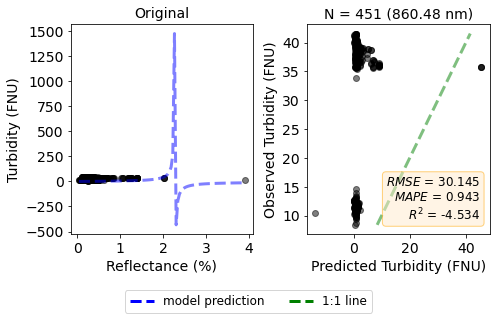

Originals params: [2.50000000e+02 2.27608608e-02]
curve fit params: [250.   1.]


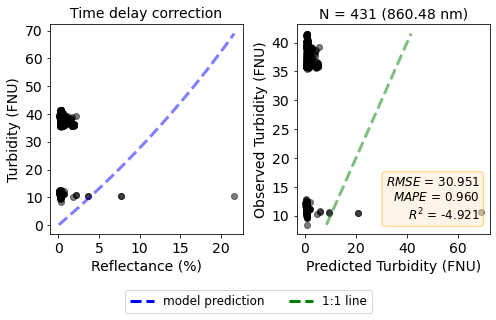

Time delay corrections params: [250.   1.]
curve fit params: [250.   1.]


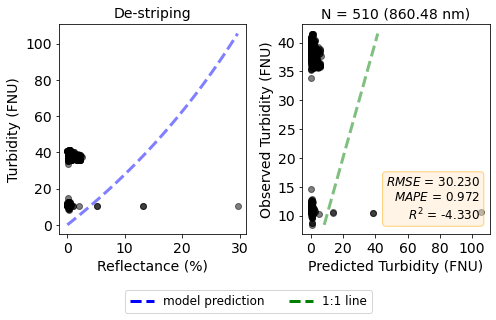

De-stripings params: [250.   1.]
curve fit params: [250.           0.52971029]


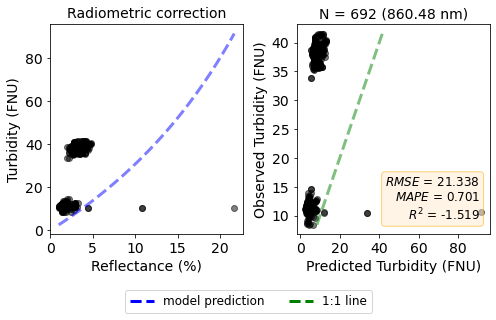

Radiometric corrections params: [250.           0.52971029]
curve fit params: [249.99999027   0.47184798]


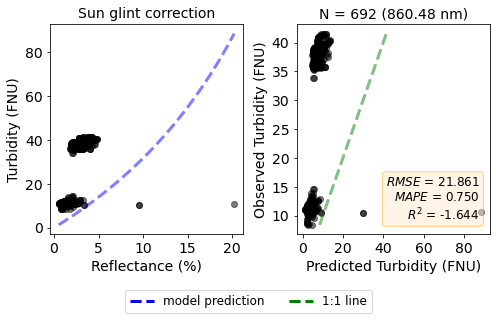

Sun glint corrections params: [249.99999027   0.47184798]


In [36]:
# for band_selected in [int(b) for b in bands_wavelengths()[::5]]:
band_selected = 860#660
for i, (title,store_fp) in enumerate(zip(titles,dirList)):
    try:
        PT = PlotTSS(store_fp)
        df_list = []
        for line_number, fp in PT.fp_dict.items():
            # line_number = 8
            df = PT.get_df(fp)
            if line_number > 6 and line_number<15:
                df_list.append(df)
        df_concat = pd.concat(df_list)
        band_number, band_name = [(i,band_number) for i,band_number in enumerate(df_concat.columns.to_list()) if band_number > band_selected][0]
        df = df_concat.iloc[:,band_number:band_number+1].dropna()
        params = PT.plot_predicted(df,band_number=0,method='curve',title=title,
                        bounds = ([0,0],[250,1]))
                                  
        print(f'{title}s params: {params}')
                        # save_fp = os.path.join(save_dir,f'{title}_band{int(band_name)}'))
    except:
        print(f'band:{band_selected} skipped')

### Linear regression fitted for each band

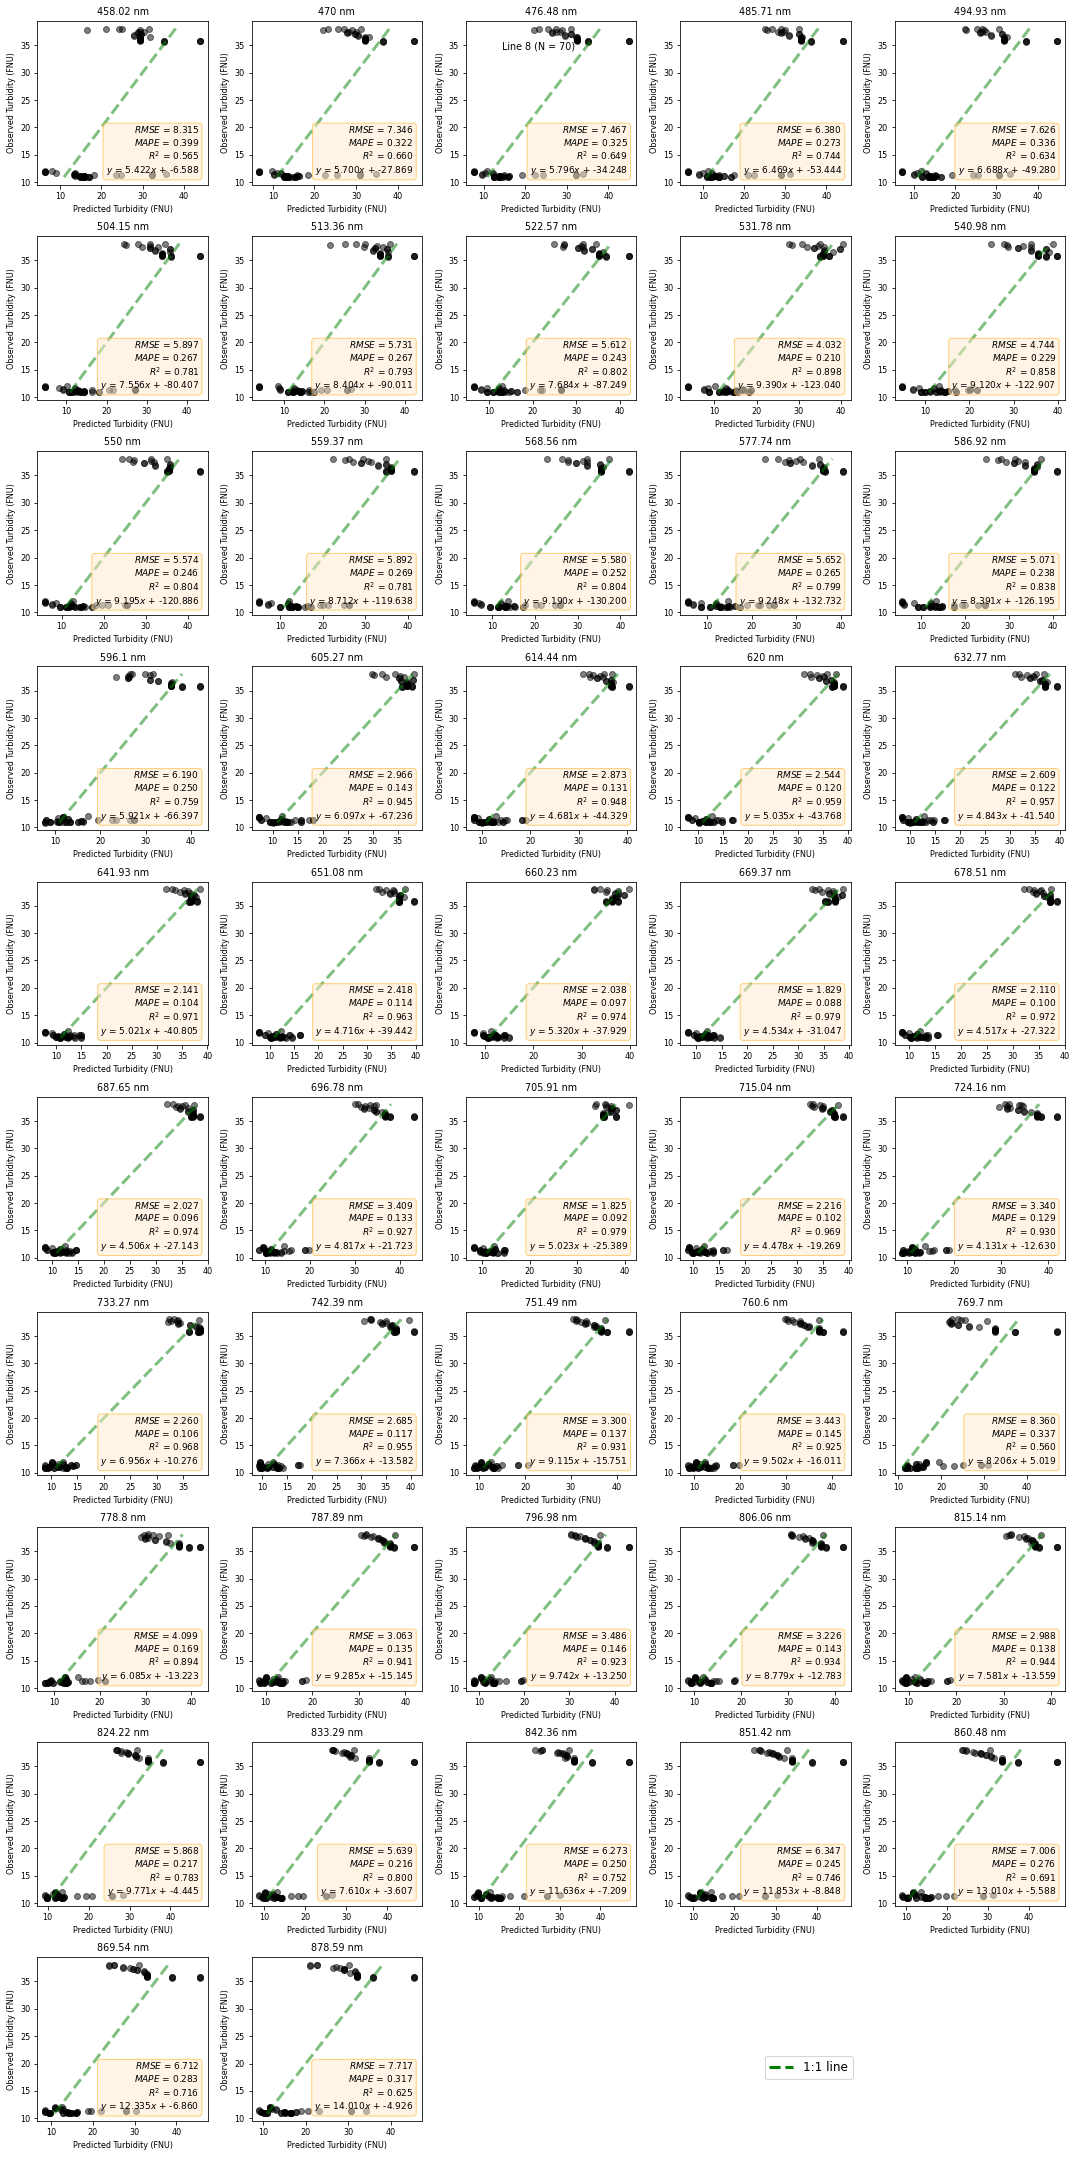

In [196]:
PT = PlotTSS(r"C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\2021_11_10_1_sgc_radiometricCorrection\Extracted_Spectral_Information")
line_number = 8
df = PT.get_df(PT.fp_dict[line_number])
df = df.iloc[:,5:-9].dropna(axis=0).dropna(axis=1)
PT.plot_predicted_bands(df)

# Extracted spectral information

In [72]:
dirList = [r"C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\2021_11_10_1_original",
           r"C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\2021_11_10_1_timedelaycorrection",
           r"C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\2021_11_10_1_destriping",
           r"C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\2021_11_10_1_radiometricCorrection",
           r"C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\2021_11_10_1_sgc_radiometricCorrection"
           ]
titles = ['Original','Time delay correction','De-striping','Radiometric correction','Sun glint correction']
save_dir = r'c:\Users\PAKHUIYING\OneDrive - Nanyang Technological University\Research_Papers\CoastalWQL\images'

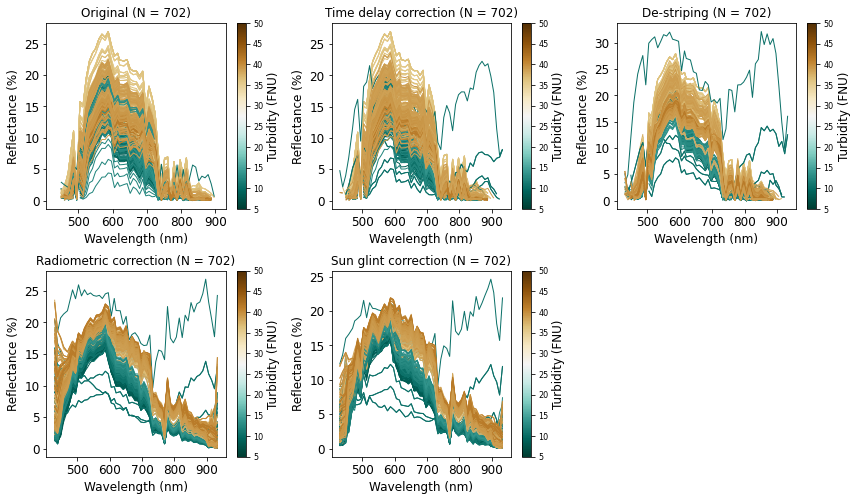

In [80]:
fig, axes = plt.subplots(2,3,figsize=(12,7))
for title, d,ax in zip(titles,dirList,axes.flatten()):
    fp = join(d,'Extracted_Spectral_Information')
    PT = PlotTSS(fp)
    PT.plot_compiled_TSS(ax=ax,norm = plt.Normalize(5,50), title=title)
plt.delaxes(ax = axes[-1,-1])
plt.tight_layout()
plt.show()

In [42]:
# image directory where raw images are stored
image_fp = "C:/Users/PAKHUIYING/Documents/image_processing/10_11_2021/10-58-10RES1280_EXP0047_GAN0030_BIT08_2EXP0000_GAN0010_RES1280_BIT08"

# spectroradiometer directory where irradiance data are stored
spectrometer_fp = "C:/Users/PAKHUIYING/Documents/image_processing/10_11_2021/11_10_2021"

# define a folder to store newly created files
fp_store = r"C:\Users\PAKHUIYING\Documents\image_processing\F3_processed_surveys\2021_11_10_1_sgcRadiometricCor_860nm"

# define a prefix for your file names, choose something that you will be able to understand later on
prefix = "band860"

# flight height (in meters) from the ground surface (sometimes GPS altitude readings are not accurate)
height = 58
gsd = compute_ground_resolution(camera_height = height)
print(f'Ground resolution: {gsd}')

# GPS index of selected points
# if the coordinate selection is used in the GUI_platform, the gps_index_txt file will be automatically saved
# an example is provided in the *inputs* folder
gps_index_txt = "C:/Users/PAKHUIYING/Documents/image_processing/F3_processed_surveys/2021_11_10_1/gps_index_2021_11_10_10-58-10.txt"

# checkboxes to conduct different pre-processing

# image segmentation to mask land/vessels
mask_checkbox = True
# de-striping of pushbroom hyperspectral images
noise_checkbox = True
# sun glint correction using SUGAR algorithm
sunglint_checkbox = True
# radiometric correction (requires spectroradiometer and irradiance data)
radiometric_checkbox = True
# turbidity prediction using Nechad's 2009 semi-analytical algorithm
predict_checkbox = True
# bands for creating the visual/rgb orthomosaic
r,g,b = 38,23,15

Ground resolution: (0.0192125, 0.38425, 19.6736)


gps indices for selected GPS points: [16, 28, 42, 59, 72, 93, 107, 133, 148, 178, 193, 226, 242, 273, 287, 320, 335, 367, 381, 413, 429, 462, 476, 503, 519, 543, 557, 576, 592, 607, 621, 631, 647, 653]
gps file path:C:/Users/PAKHUIYING/Documents/image_processing/10_11_2021/10-58-10RES1280_EXP0047_GAN0030_BIT08_2EXP0000_GAN0010_RES1280_BIT08/UAV/gps_10-59-41-615.csv


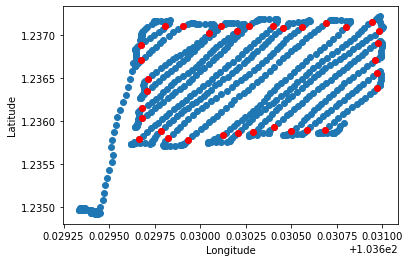

Image indices: [(686, 1218), (1836, 2573), (3142, 4052), (4666, 5777), (6418, 7730), (8386, 9809), (10504, 11826), (12434, 13781), (14441, 15853), (16429, 17768), (18383, 19717), (20280, 21369), (22017, 23003), (23594, 24386), (25069, 25705), (26265, 26638), (27315, 27579)]
Start line: 0, Stop line: 17
corrected indices: [[685, 1218], [1750, 2494], [3124, 4032], [4583, 5699], [6417, 7728], [8301, 9720], [10452, 11765], [12357, 13705], [14384, 15787], [16375, 17714], [18333, 19667], [20226, 21317], [21961, 22943], [23533, 24337], [25023, 25652], [26219, 26587], [27264, 27523]]


In [43]:
gps_indices = read_gps_index(gps_index_txt)
print(f'gps indices for selected GPS points: {gps_indices}')
# Alternatively, u can manually input the indices as a list, e.g.
# gps_indices = [15, 47, 63, 94, 111, 144, 159, 193, 206, 239, 254, 286, 302, 334, 349, 381, 396, 429, 446, 480, 495, 527]
# but note that it may affect the stitching quality if the GPS points selected are not well chosen (e.g. chosen arbitrarily)

gps_df = import_gps(image_fp)
unique_gps_df = get_unique_df(gps_df)
plot_GPS(unique_gps_df,gps_indices)

# account for flipping of images when imaging direction is reversed
reverse_boolean_list = rev_boolean_list(unique_gps_df,gps_indices)

# Nap GPS indices to image indices
indexes_list = gps_to_image_indices(unique_gps_df,image_fp,gps_indices, millisecond_delay = 0)
print(f'Image indices: {indexes_list}')

# number of flight lines
line_start = 0
line_stop = len(indexes_list)
print(f'Start line: {line_start}, Stop line: {line_stop}')

# load the saved corrected_indices
corrected_indices = [[685, 1218], [1750, 2494], [3124, 4032], [4583, 5699], [6417, 7728], [8301, 9720], [10452, 11765], [12357, 13705], [14384, 15787], [16375, 17714], [18333, 19667], [20226, 21317], [21961, 22943], [23533, 24337], [25023, 25652], [26219, 26587], [27264, 27523]]

print(f'corrected indices: {corrected_indices}')

# update indexes_list based on the alignment
if corrected_indices is not None:
    indexes_list = corrected_indices

In [44]:
config_file = {'-PROCESSED_IMAGES-':fp_store,'-PREFIX-':prefix,'-IMAGE_FOLDER_FILEPATH-':image_fp,\
                '-SPECTRO_FILEPATH-':spectrometer_fp,\
                '-HEIGHT-':height,'-GPS_INDEX_TXT-':gps_index_txt,\
                '-LINE_START-':line_start,'-LINE_END-':line_stop,'rgb_bands':[r,g,b],\
                '-MASK_CHECKBOX-':mask_checkbox,\
                '-RADIOMETRIC_CHECKBOX-':radiometric_checkbox,'-NOISE_CHECKBOX-':noise_checkbox,\
                '-SUNGLINT_CHECKBOX-':sunglint_checkbox,'-PREDICT_CHECKBOX-':predict_checkbox,\
                'corrected_indices':corrected_indices}

In [45]:
class StitchBand:
# (image_folder_filepath,spectro_filepath,overlap_ratio,start_index,end_index,s1_bands_fp='s1_bands.csv',Reflectance_White_Ref=95):
    def __init__(self,fp_store,prefix,image_folder_filepath,spectro_filepath,\
        height,band_number,line_number,start_index,end_index,\
        test_gps_index, unique_gps_df,destriping=True,\
        Reflectance_White_Ref=95,reverse=True):
        
        # directories to store images
        self.fp_store = fp_store
        self.glint_directory = "Glint_corrected"
        self.prediction_directory = 'Prediction'
        self.rgb_reflectance_directory = 'rgb_reflectance'
        self.hyperspectral_directory = 'Hyperspectral'
        self.mask_directory = 'Mask'
        # instance variable unique to each image
        self.prefix = prefix
        self.image_folder_filepath = image_folder_filepath
        self.spectro_filepath = spectro_filepath
        self.height = height
        self.band_number = band_number
        self.line_number = line_number
        self.start_index = start_index
        self.end_index = end_index
        self.test_gps_index = test_gps_index
        self.unique_gps_df = unique_gps_df
        self.destriping = destriping
        self.Reflectance_White_Ref = Reflectance_White_Ref
        self.reverse = reverse
        #constants
        self.band_width = int(1280/61)
        self.band_numbers = int(61)
        self.rgb_bands = [38,23,15]
        # file paths
        self.rgb_fp = '{}_rgb_image_line_{}_{}_{}.tif'.format(self.prefix,str(self.line_number).zfill(2),self.start_index,self.end_index)
        self.rgb_reflectance_fp = self.rgb_fp.replace('rgb',self.rgb_reflectance_directory)
        # just let deglinted reflectance img have the same fn as rgb_reflectance
        self.rgb_deglinted_fp = self.rgb_reflectance_fp
        self.predicted_fp = self.rgb_fp.replace('rgb','predicted')
        self.mask_fp = self.rgb_fp.replace('rgb_image','mask')#f'{self.prefix}_mask_line_{str(self.line_number).zfill(2)}_{self.start_index}_{self.end_index}.png'


    def get_camera_settings(self,filepath):
        """ 
        GET IMAGE ATTRIBUTE of calibration files (white & dark)
        input is the image folder filepath
        outputs (exposure time of sensor 1 , datetime)
        >>>get_camera_settings(filepath)
        """
        image_result = re.search('EXP(.*)_RES', filepath).group(0)
        # print(filepath)
        date_time = datetime.strptime(filepath[:19], "%Y-%m-%d_%H-%M-%S")
        #split image_result by delimiter
        image_result = image_result.split('_')
        img_exp_s1 = image_result[0]
        img_exp_s1 = float(img_exp_s1.replace('EXP',''))/10
        return img_exp_s1, date_time

    def get_spectroradiometer_data(self,date_time):
        """ 
        GET SPECTRORADIOMETER DATA
        inputs are spectrometer filepath and date_time when the image was taken
        outputs spectroradiometer df
        >>>get_spectroradiometer_data(spectro_filepath,date_time)
        """
        delta = timedelta(seconds = 1)
        string_to_match = date_time.strftime("%m_%d_%Y_AbsoluteIrradiance_%H-%M-%S")
        next_time = date_time + delta
        
        filtered_files = [f for f in sorted(listdir(self.spectro_filepath)) if re.match('^.*{}.*'.format(string_to_match), f)]
        if len(filtered_files) == 0: #if image timestamp not inside spectroradiometer folder, try next sec timestamp
            string_to_match = next_time.strftime("%m_%d_%Y_AbsoluteIrradiance_%H-%M-%S")
            filtered_files = [f for f in sorted(listdir(self.spectro_filepath)) if re.match('^.*{}.*'.format(string_to_match), f)]
            if len(filtered_files) == 0: #if still not inside folder, likely that timestamp is wrong
                raise NameError('Timestamps dont match!')
        
        try:
            filepath = self.spectro_filepath + '/' + filtered_files[0]
            #dataframe of wavelength and the corresponding irradiance
            column_name = string_to_match.replace('_AbsoluteIrradiance','')
            df = pd.read_csv(filepath, delimiter = "\t",header=None,skiprows=13,names=['wavelength',column_name])
        except OSError as err:
            print("File cant be opened - OS error: {0}".format(err))

        return df

    def calibration_attributes(self):
        """ 
        GET calibration attributes e.g. DN_max, DN_avg
        inputs image_folder_filepath
        outputs a nested dictionary of calibration dictionary where keys are 'White' and 'Dark'
        >>>calibration_attributes(image_folder_filepath)
        """
        Dark_fp = join(self.image_folder_filepath, 'Dark')
        White_fp = join(self.image_folder_filepath, 'WhiteRef')
        calibration_list = [White_fp,Dark_fp] #0 is white, 1 is black
        calibration_dictionary = {} #create empty dictionary
        for i in range(len(calibration_list)):
            calib_img = [f for f in sorted(listdir(calibration_list[i])) if isfile(join(calibration_list[i], f))] #list files in folder
            calib_fp_list = [join(calibration_list[i],f) for f in calib_img] #create absolute filepath
            scene_infile_list = [open(f,'rb') for f in calib_fp_list]
            scene_image_array_list = [np.fromfile(scene_infile,dtype=np.uint8,count=1280*1024) for scene_infile in scene_infile_list]
            scene_image_array = np.mean(scene_image_array_list,axis=0)
            
            exposure,dt = self.get_camera_settings(calib_img[0]) #use the function above
            img_dict = {'raw_file':scene_image_array,'exp_time':exposure,'datetime':dt}

            calibration_dictionary[i] = img_dict
        #rename dictionary keys
        calibration_dictionary['White'] = calibration_dictionary.pop(0)
        calibration_dictionary['Dark'] = calibration_dictionary.pop(1)
        return calibration_dictionary #returns nested dictionary
    
    def raw_attributes(self):
        """ 
        GET raw images attributes
        outputs a nested dictionary where keys are name of image file, and values are dictionary of raw image array, exposure time and datetime
        >>>raw_attributes(image_folder_filepath,date,start_index,end_index)
        """
        image_result = re.search('EXP(.*)_RES', self.image_folder_filepath).group(0)
        image_result = image_result.split('_')
        img_exp_s1 = image_result[0]
        img_exp_s1 = float(img_exp_s1.replace('EXP',''))/10
        calib_info = self.calibration_attributes()
        date = calib_info['White']['datetime']

        fp = join(self.image_folder_filepath, 'RawImages')
        rawfiles = [f for f in sorted(listdir(fp)) if isfile(join(fp, f))]
        # rawfiles_indexed = rawfiles[self.start_index:self.end_index]
        rawfiles_indexed = rawfiles[self.start_index:self.end_index+1]
        timestamps = ['-'.join(t.split('_')[2].split('-')[:3]) for t in rawfiles_indexed]
        # timestamps = [re.search('_(.*)-', t).group(1)[5:] for t in rawfiles_indexed]
        date_formatted = date.strftime('%m-%d-%Y')
        timestamps = [date_formatted + '_' + t for t in timestamps]
        dt = [datetime.strptime(t,'%m-%d-%Y_%H-%M-%S') for t in timestamps]
        img_dict = {}
        for i in range(len(rawfiles_indexed)):
            scene_infile = open(fp + '/' + rawfiles_indexed[i],'rb')
            scene_image_array = np.fromfile(scene_infile,dtype=np.uint8,count=1280*1024)
            #key is the name of the image file, value is the datetime
            img_dict[rawfiles_indexed[i]] = {'raw_file':scene_image_array,'exp_time': img_exp_s1,'datetime':dt[i]} #dt[i]
        return img_dict

    def get_spec_calib(self):
        """ 
        get spectrometer calibration info 
        outputs a df with spectrometer data and datetime for raw images
        *Note: use this function to obtain combined_df
        >>>get_spec_calib(image_folder_filepath,spectro_filepath)
        """
        print("Getting spectroradiometer data...")
        calib_info = self.calibration_attributes() #nested dictionary
        # date = calib_info['White']['datetime']
        # raw_exposure, raw_dt = get_camera_settings(image_folder_filepath)
        # print(raw_exposure,raw_dt)
        # create df of spectroradiometer data for dark and white ref
        spec_calib = []
        for calib_type, attr_dict in calib_info.items():
            calib_df = self.get_spectroradiometer_data(attr_dict['datetime'])
            calib_df.rename(columns={ calib_df.columns[1]: calib_df.columns[1]+'_'+calib_type }, inplace = True)
            calib_df.set_index('wavelength',inplace=True)
            spec_calib.append(calib_df)
        
        spec_calib_dfs = pd.concat(spec_calib,axis=1)
        
        s1_bands = bands_wavelengths()#self.get_s1_bands()
        spec_bands = spec_calib_dfs.index
        spec_bands_index = [] #istantiate empty list to store index of spec_bands
        s1_band_count = 0 #initialise as the first band
        for k,v in enumerate(spec_bands):
            # print(k,v)
            if s1_band_count==len(s1_bands):
                break
            else:
                if v>s1_bands[s1_band_count]:
                    spec_bands_index.append(k)
                    s1_band_count+=1
        
        #subset rows from spec_calib_dfs
        spec_calib_dfs = spec_calib_dfs.iloc[spec_bands_index,:]

        spec_raw = []
        # date = calib_info['White']['datetime']
        raw_info = self.raw_attributes() #nested dictionary
        for img_name, attr_dict in raw_info.items():
            raw_df = self.get_spectroradiometer_data(attr_dict['datetime'])
            #subset rows from spec_calib_dfs
            raw_df = raw_df.iloc[spec_bands_index,:]
            raw_df.rename(columns={raw_df.columns[1]: raw_df.columns[1]+'_'+img_name}, inplace = True)
            raw_df.set_index('wavelength',inplace=True)
            spec_raw.append(raw_df)
        
        # spec_raw_dfs = pd.concat([df.set_index('wavelength') for df in spec_raw],axis=1)
        spec_raw_dfs = pd.concat(spec_raw,axis=1)
        combined_df = pd.concat([spec_raw_dfs,spec_calib_dfs],axis=1)
        return combined_df
    
    # def get_calibration_curve(self,curve_fitting_correction_fp):
    def get_calibration_curve(self):
        """
        curve_fitting_correction_fp (str): fp to the csv file that contains parameters for the best fit cubic curve for each wavelength
        returns a df with columns 'wavelength', 'w_a', 'w_b', 'w_c', 'w_d', 'd_a', 'd_b', 'd_c', 'd_d', 'irr_cutoff'
        """
        try:
            # df = pd.read_csv(curve_fitting_correction_fp)
            df_dict = calibration_curve()
            df = pd.DataFrame.from_dict(df_dict)
        except:
            # print("curve_fitting_correction_fp: {} cannot be found!".format(curve_fitting_correction_fp))
            df == None
        
        return df


    def get_naive_stitched(self):
        """ 
        outputs band_list of naive_stitched in the form of a dictionary. keys are band number, values are image array
        >>>get_naive_stitched()
        """
       
        raw_info = self.raw_attributes()

        print("Performing correction...")

        band_list = {} #store all the separate bands
        # print("Stitching images...({} perc overlap ratio)".format(round(self.overlap_ratio,2)))

        for i in range(self.band_number, self.band_number+1): #61 bands are evenly distributed across rows
            image_array = [] #uncorrected
            
            for (_,raw_attr) in raw_info.items(): #iterate across images #enumerate across dictionary  
                f = raw_attr['raw_file']
                reshaped_raw = f.reshape(1024,1280)
                row_start = i*self.band_width
                row_end = i*self.band_width + self.band_width
                band_array = reshaped_raw[:,row_start:row_end]
                image_array.append(band_array)

            naive_stitched = np.hstack(image_array) #stitch all images together
            band_list[i] = naive_stitched

        return band_list

    def get_reflectance_naive_stitched(self,curve_fitting_correction_fp=None):
        """ 
        correct images
        outputs band_list of reflectance naive stitched img in the form of a dictionary. keys are band number, values are corrected reflectance array
        >>>get_reflectance_naive_stitched()
        """
      
        spec_df = self.get_spec_calib()
        calib_info = self.calibration_attributes() #keys: White, Dark, sub keys: raw_file,exp_time, datetime
        # date = calib_info['White']['datetime']
        raw_info = self.raw_attributes()

        exp_white = calib_info['White']['exp_time']
        exp_dark = calib_info['Dark']['exp_time']

        if curve_fitting_correction_fp is None:
            print("Performing correction...")
        else:
            calibration_curve_df = self.get_calibration_curve()
            print("Performing correction using calibration curve...")

        #calibration curve fn
        def cubic_fn(x,a,b,c,d):
            """
            where x is the radiance
            returns the corrected DN i.e. DN/exp_time
            """
            y = a*x**3 + b*x**2 + c*x + d
            return y if y >0 else 0
        
        def reflectance_eqn(corrected_raw,corrected_white,corrected_dark):
            if corrected_raw > corrected_white:
                return self.Reflectance_White_Ref
            elif corrected_raw < corrected_dark:
                return 0
            else:
                return (corrected_raw - corrected_dark)/(corrected_white - corrected_dark)*self.Reflectance_White_Ref

        band_list = {} #store all the separate bands
        #band_list_overlapped = [] #store all the separate bands
        # print("Stitching images...({} perc overlap ratio)".format(round(self.overlap_ratio,2)))

        for i in range(self.band_number, self.band_number+1): #61 bands are evenly distributed across rows
            image_array = [] #uncorrected
            reflectance_image_array = [] #corrected & transformed to reflectance units
            for calib_name,calib_attr in calib_info.items():
                f = calib_attr['raw_file']
                reshaped_raw = f.reshape(1024,1280)
                row_start = i*self.band_width
                row_end = i*self.band_width + self.band_width
                band_array = reshaped_raw[:,row_start:row_end]
                # calib_info[calib_name][i] = np.mean(band_array) #mean DN and assign it the band number
                calib_info[calib_name][i] = np.max(band_array) #for both dark and white ref

            for j,(_,raw_attr) in enumerate(raw_info.items()): #iterate across images #enumerate across dictionary  
                f = raw_attr['raw_file']
                reshaped_raw = f.reshape(1024,1280)
                row_start = i*self.band_width
                row_end = i*self.band_width + self.band_width
                band_array = reshaped_raw[:,row_start:row_end]
                image_array.append(band_array)
                #perform correction on the line image (band_array)
                exp_raw = raw_attr['exp_time']
                new_radiance = spec_df.iloc[i,j] #indexing band & image
                old_radiance = spec_df.iloc[i,-2] #indexing band & White column
                White = calib_info['White'][i]
                Dark = calib_info['Dark'][i]
                if curve_fitting_correction_fp is None or calibration_curve_df is None:
                    new_White = new_radiance/old_radiance * White
                    reflectance_formula = lambda DN,White_DN: (DN/exp_raw)/(White_DN/exp_white)*self.Reflectance_White_Ref if ((White_DN - Dark) < 0.5) else self.Reflectance_White_Ref*((DN/exp_raw)-(Dark/exp_dark))/((White_DN/exp_white)-(Dark/exp_dark))
                    corrected_band_array = reflectance_formula(band_array,new_White) #np.array(map(reflectance_formula, band_array))
                else:
                    w_a, w_b, w_c, w_d, d_a, d_b, d_c, d_d, w_a_max, w_b_max, w_c_max, w_d_max, d_a_max, d_b_max, d_c_max, d_d_max, irr_cutoff = calibration_curve_df.iloc[i,1:]
                    corrected_White = cubic_fn(new_radiance,w_a, w_b, w_c, w_d)
                    corrected_Dark = cubic_fn(new_radiance,d_a, d_b, d_c, d_d)
                    corrected_Raw = band_array/exp_raw
                    corrected_band_array = reflectance_eqn(corrected_Raw,corrected_White,corrected_Dark)

                reflectance_image_array.append(corrected_band_array)

            reflectance_stitched = np.hstack(reflectance_image_array) #stitch all reflectance images together
            #keys are the wavelengths, values is another dictionary--> band_list is a nested dictionary
            band_list[i] = reflectance_stitched

        return band_list

    def get_overlap_ratios_per_line(self):
        """
        calculate overlap ratios per flight line. Cannot assume that overlap ratio is constant across the flight line
        number_of_image_slices (int): len(image_array) that corresponds the number of image slices
        frame_rate is not constant throughout flight
        >>>get_overlap_ratios_per_line()
        """
        # rawfiles = [f for f in sorted(listdir(self.image_folder_filepath)) if isfile(join(self.image_folder_filepath, f))]
        
        test_gps_list = [(self.test_gps_index[i],self.test_gps_index[i+1]) for i in range(0,len(self.test_gps_index),2)]
        gps_start_index,gps_end_index = test_gps_list[self.line_number]
        intermediate_gps_pts = self.unique_gps_df.iloc[gps_start_index:gps_end_index+1,[1,2,6,8]] #latitude, longitude, datetime,image_index (float)
        # frame_rate = 50
        pixel_size_at_sensor = 5.3 #um
        total_pixel_of_sensor_x = self.band_width#int(1280/61) #because hyperspectral images are line images, so actual pixel_x is 20
        focal_length = 16 #mm
        actual_size_of_sensor_x = pixel_size_at_sensor*total_pixel_of_sensor_x/1000 #mm
        fov_x = 2*math.atan(actual_size_of_sensor_x/2/focal_length)*180/math.pi #deg
        total_gnd_coverage_x = 2*self.height*math.tan(math.pi*fov_x/2/180) #metres #angle is converted to radians first
        # band_width = int(1280/61)


        lat_start, lon_start = intermediate_gps_pts.iloc[0,[0,1]].values
        lat_end, lon_end = intermediate_gps_pts.iloc[-1,[0,1]].values
        image_index_start = int(intermediate_gps_pts.iloc[0,3]) #cast float to int
        image_index_end = int(intermediate_gps_pts.iloc[-1,3]) #cast float to int
        time_diff = intermediate_gps_pts.iloc[-1,2] - intermediate_gps_pts.iloc[0,2]
        time_diff = time_diff.total_seconds()
        frame_rate = int((image_index_end - image_index_start)/time_diff)
        dist = Haversine((lon_start,lat_start),(lon_end,lat_end)).meters
        speed = dist/time_diff
        # print("Avg speed of drone: {:.2f}, Avg frame rate: {}".format(speed,frame_rate))
        d = (1/frame_rate)*speed #distance covered by drone in 1 fps
        overlap_x = total_gnd_coverage_x - d
        overlap_x_ratio = overlap_x/total_gnd_coverage_x #in ratio instead of percentage
        if overlap_x_ratio < 0: #or overlap_x_ratio > 1:
            print("Overlap_x_ratio < 0. Overlap ratio set as 0. Stitching will not be accurate!")
            overlap_x_ratio = 0
        elif overlap_x_ratio > 1:
            print("Overlap_x_ratio > 1. Overlap ratio set as 1. Stitching will not be accurate!")
            overlap_x_ratio = 1
        
        overlapped_cols = int(overlap_x_ratio*self.band_width) 
        # OR_x_list.append([(i,i+1), overlap_x_ratio])
        # OR_x_list = {'image_frames_list':[image_index_end - image_index_start],'OR_list':[overlapped_cols]}
        return overlapped_cols#OR_x_list

      

    def trimm_image(self,image_array):
        """ 
        conduct linear blending for an image array
        inputs:
        image_array (list of np array): greyscale slices of a band
        overlap_ratios_per_line (dictionaries): contains information on image_frames_range & overlapped_cols for adaptive overlap ratio
            keys of the dictionaries are:
                image_frames_list: contains a list of image frame index, 
                OR_list: contains a list of OR that corresponds to the overlapped cols for this image_frame and the prev one
        """
        overlapped_cols = self.get_overlap_ratios_per_line()
        trimmed_initial = [image_array[0]]
        trimmed_subsequent = [img[:,overlapped_cols:self.band_width] for img in image_array[1:]]
        trimmed_image_array = trimmed_initial+trimmed_subsequent
        stitched_img = np.hstack(trimmed_image_array)
        return stitched_img if self.reverse is False else np.fliplr(stitched_img)
       

    def get_stitched_img(self,destriping_fp="destriping_array.csv"):
        """ 
        outputs band_list of stitched img in the form of a dictionary. keys are band number, values are image array
        >>>get_stitched_img()
        """
        try:
            destriping_array = np.loadtxt(destriping_fp,delimiter=',')
        except Exception as E:
            print("Destriping array cannot be imported. Destriping of rgb images aborted.")
            destriping_array = np.ones((self.band_numbers,1024))
        raw_info = self.raw_attributes()
        print("generating hyperspectral images...")

        white_fp = join(self.image_folder_filepath,"WhiteRef")
        fp_list_white = [join(white_fp,i) for i in listdir(white_fp)]
        hyperspectral_img_list_white = [raw_to_hyperspectral_img(f) for f in fp_list_white]
        hyperspectral_white = np.mean(hyperspectral_img_list_white,axis=0)
        hyperspectral_white_array = np.mean(hyperspectral_white,axis=1)

        def destriping_img(img,hyperspectral_white_array,band):
            """
            destriping array.shape = (61,1024)
            """
            adjust_DN = lambda x,max_DN: max_DN/x
            avg_DN = hyperspectral_white_array[:,band]
            max_DN = np.max(avg_DN)
            avg_DN = np.where(avg_DN <=0,1,avg_DN)
            corrected_DN = adjust_DN(avg_DN,max_DN)

            nrows,ncols = img.shape
            adjust_DN_rgb = np.transpose(corrected_DN) #1D array
            repeated_DN_rgb = np.repeat(adjust_DN_rgb[:,np.newaxis],ncols,axis=1)
            destriped_img = repeated_DN_rgb*img
            destriped_img = np.where(destriped_img>255,255,destriped_img)
            return destriped_img.astype(np.uint8)

        band_list = {} #store all the separate bands
        # print("Stitching images...({} perc overlap ratio)".format(round(self.overlap_ratio,2)))
        
        for i in range(self.band_number, self.band_number+1): #61 bands are evenly distributed across rows
            image_array = [] #uncorrected
            for (_,raw_attr) in raw_info.items(): #iterate across images #enumerate across dictionary  
                f = raw_attr['raw_file']
                reshaped_raw = f.reshape(1024,1280)
                row_start = i*self.band_width
                row_end = i*self.band_width + self.band_width
                band_array = reshaped_raw[:,row_start:row_end]
                image_array.append(band_array)

            # band_list[i] = self.trimm_image(image_array)
            stitched_img = self.trimm_image(image_array)
            # destriped_img = destriping_img(stitched_img,destriping_array,i)
            destriped_img = destriping_img(stitched_img,hyperspectral_white_array,i)
            band_list[i] = destriped_img
            # overlap_ratios_per_line = self.get_overlap_ratios_per_line(len(image_array))
            # band_list[i] = self.trimm_image(image_array,overlap_ratios_per_line)

        return band_list
    
    def get_stitched_uncorrected_reflectance(self):
        """ 
        outputs band_list in reflectance values in % (i.e. values between 0 to 100)
        """
        def destriping_img(img,hyperspectral_white_array,band):
            """
            destriping array.shape = (61,1024)
            """
            adjust_DN = lambda x,max_DN: max_DN/x
            avg_DN = hyperspectral_white_array[:,band]
            max_DN = np.max(avg_DN)
            avg_DN = np.where(avg_DN <=0,1,avg_DN)
            corrected_DN = adjust_DN(avg_DN,max_DN)

            nrows,ncols = img.shape
            adjust_DN_rgb = np.transpose(corrected_DN) #1D array
            repeated_DN_rgb = np.repeat(adjust_DN_rgb[:,np.newaxis],ncols,axis=1)
            destriped_img = repeated_DN_rgb*img
            destriped_img = np.where(destriped_img>255,255,destriped_img)
            return destriped_img.astype(np.uint8)
        # Note: raw_info is only for one image_folder
        # if (self.overlap_ratio<5):
        #     print("Enter a higher overlap ratio")
        # band_width = int(1280/61)
        calib_info = self.calibration_attributes()
        # date = calib_info['White']['datetime']
        raw_info = self.raw_attributes()
        exp_white = calib_info['White']['exp_time']
        exp_dark = calib_info['Dark']['exp_time']

        white_fp = join(self.image_folder_filepath,"WhiteRef")
        fp_list_white = [join(white_fp,i) for i in listdir(white_fp)]
        hyperspectral_img_list_white = [raw_to_hyperspectral_img(f) for f in fp_list_white]
        hyperspectral_white = np.mean(hyperspectral_img_list_white,axis=0)
        hyperspectral_white_array = np.mean(hyperspectral_white,axis=1)

        print("No correction conducted!")
        #no need for calibration curve because we are not interpolating the new irradiance, so DN_white and DN_dark stays fixed
        def reflectance_eqn(raw,white,dark):
            if raw > white:
                return self.Reflectance_White_Ref
            elif raw < dark:
                return 0
            else:
                if abs(white - dark) < 0.001:
                    return 0
                else:
                    return (raw - dark)/(white - dark)*self.Reflectance_White_Ref

        vectorised_reflectance_eqn = np.vectorize(reflectance_eqn)
        band_list = {} #store all the separate bands
        #band_list_overlapped = [] #store all the separate bands
        # print("Stitching images...({} perc overlap ratio)".format(round(self.overlap_ratio,2)))
        
        for i in range(self.band_number, self.band_number+1): #61 bands are evenly distributed across rows
            image_array = [] #uncorrected
            uncor_reflectance_image_array = [] #uncorrected & transformed to reflectance units
            for calib_name,calib_attr in calib_info.items():
                f = calib_attr['raw_file']
                reshaped_raw = f.reshape(1024,1280)
                row_start = i*self.band_width
                row_end = i*self.band_width + self.band_width
                band_array = reshaped_raw[:,row_start:row_end]
                # calib_info[calib_name][i] = np.mean(band_array) #mean DN and assign it the band number
                calib_info[calib_name][i] = np.max(band_array) #for both dark and white ref

            for (_,raw_attr) in raw_info.items(): #iterate across images #enumerate across dictionary  
                f = raw_attr['raw_file']
                reshaped_raw = f.reshape(1024,1280)
                row_start = i*self.band_width
                row_end = i*self.band_width + self.band_width
                band_array = reshaped_raw[:,row_start:row_end]
                if self.destriping is True:
                    band_array = destriping_img(band_array, hyperspectral_white_array,i)
                image_array.append(band_array)
                #perform correction on the line image (band_array)
                exp_raw = raw_attr['exp_time']
                White = calib_info['White'][i]
                Dark = calib_info['Dark'][i]
                # reflectance_formula = lambda DN,White_DN: (DN/exp_raw)/(White_DN/exp_white)*self.Reflectance_White_Ref if ((White_DN - Dark) < 0.5) else self.Reflectance_White_Ref*((DN/exp_raw)-(Dark/exp_dark))/((White_DN/exp_white)-(Dark/exp_dark))
                # uncorrected_band_array = reflectance_formula(band_array,White)
                uncorrected_raw = band_array/exp_raw
                uncorrected_white = White/exp_white
                uncorrected_dark = Dark/exp_dark
                uncorrected_band_array = vectorised_reflectance_eqn(uncorrected_raw,uncorrected_white,uncorrected_dark)
                # uncorrected_band_array = reflectance_eqn(uncorrected_raw,uncorrected_white,uncorrected_dark)
                uncor_reflectance_image_array.append(uncorrected_band_array)

            # overlap_ratios_per_line = self.get_overlap_ratios_per_line(len(uncor_reflectance_image_array))
            #keys are the wavelengths, values is another dictionary--> band_list is a nested dictionary
            # band_list[i] = self.trimm_image(uncor_reflectance_image_array,overlap_ratios_per_line)
            band_list[i] = self.trimm_image(uncor_reflectance_image_array)
             #nested dictionary

        # save the rgb reflectance img
        # self.get_rgb_reflectance_img(band_list)
        return band_list

    # def get_stitched_reflectance(self,curve_fitting_correction_fp=None,destriping_fp="destriping_array.csv"):
    def get_stitched_reflectance(self,curve_fitting_correction=True):
        """ 
        correction wrt to downwelling irradiance images
        outputs band_list of reflectance naive stitched img in the form of a dictionary. keys are band number, values are corrected reflectance array
        Must perform destriping before converting to reflectances since units are different.
        Destriping is performed on raw DN
        Must perform radiometric correction for each individual frame before stitching them up because irradiance for image frames is different
        >>>get_stitched_reflectance()
        """
       
        spec_df = self.get_spec_calib()
        calib_info = self.calibration_attributes()
        # date = calib_info['White']['datetime']
        raw_info = self.raw_attributes()

        exp_white = calib_info['White']['exp_time']
        exp_dark = calib_info['Dark']['exp_time']

        if curve_fitting_correction is False:
            print("Performing correction...")
            print("Linear radiometric calibration...")
        else:
            calibration_curve_df = self.get_calibration_curve()
            print("Performing correction using calibration curve...")
            print("Cubic function calibration...")

     
        white_fp = join(self.image_folder_filepath,"WhiteRef")
        fp_list_white = [join(white_fp,i) for i in listdir(white_fp)]
        hyperspectral_img_list_white = [raw_to_hyperspectral_img(f) for f in fp_list_white]
        hyperspectral_white = np.mean(hyperspectral_img_list_white,axis=0)
        hyperspectral_white_array = np.mean(hyperspectral_white,axis=1)

        def destriping_img(img,hyperspectral_white_array,band):
            """
            destriping array.shape = (61,1024)
            """
            adjust_DN = lambda x,max_DN: max_DN/x
            avg_DN = hyperspectral_white_array[:,band]
            max_DN = np.max(avg_DN)
            avg_DN = np.where(avg_DN <=0,1,avg_DN)
            corrected_DN = adjust_DN(avg_DN,max_DN)

            nrows,ncols = img.shape
            adjust_DN_rgb = np.transpose(corrected_DN) #1D array
            repeated_DN_rgb = np.repeat(adjust_DN_rgb[:,np.newaxis],ncols,axis=1)
            destriped_img = repeated_DN_rgb*img
            destriped_img = np.where(destriped_img>255,255,destriped_img)
            return destriped_img.astype(np.uint8)
        #calibration curve fn
        def cubic_fn(x,a,b,c,d):
            """
            used to interpolate corrected DN given a radiance value
            where x is the radiance
            a,b,c,d = parameters of cubic curve fitting
            returns the corrected DN i.e. DN/exp_time
            """
            y = a*x**3 + b*x**2 + c*x + d
            return y if y >0 else 0
        
        def reflectance_eqn(corrected_raw,corrected_white,corrected_dark):
            """
            corrected means DN/exp_time
            """
            if corrected_raw > corrected_white:
                return float(self.Reflectance_White_Ref)
            elif corrected_raw < corrected_dark:
                return 0.0
            else:
                if abs(corrected_white - corrected_dark) < 0.001:
                    return 0.0
                else:
                    return (corrected_raw - corrected_dark)/(corrected_white - corrected_dark)*self.Reflectance_White_Ref

        vectorised_reflectance_eqn = np.vectorize(reflectance_eqn)

        band_list = {} #store all the separate bands
        
        for i in range(self.band_number, self.band_number+1): #61 bands are evenly distributed across rows
            reflectance_image_array = [] #corrected & transformed to reflectance units for a wavelength
            for calib_name,calib_attr in calib_info.items():
                f = calib_attr['raw_file']
                reshaped_raw = f.reshape(1024,1280)
                row_start = i*self.band_width
                row_end = i*self.band_width + self.band_width
                band_array = reshaped_raw[:,row_start:row_end]
                calib_info[calib_name][i] = np.mean(band_array) #mean DN and assign it the band number
                # calib_info[calib_name][i] = np.max(band_array) #for both dark and white ref
                
            for j,(_,raw_attr) in enumerate(raw_info.items()): #iterate across images #enumerate across dictionary  
                f = raw_attr['raw_file']
                reshaped_raw = f.reshape(1024,1280)
                row_start = i*self.band_width
                row_end = i*self.band_width + self.band_width
                band_array = reshaped_raw[:,row_start:row_end]
                if self.destriping is True:
                    band_array = destriping_img(band_array, hyperspectral_white_array,i)
                #perform correction on the line image (band_array)
                exp_raw = raw_attr['exp_time']
                new_radiance = spec_df.iloc[i,j] #indexing band & image
                old_radiance = spec_df.iloc[i,-2] #indexing band & White column
                White = calib_info['White'][i] #mean DN of white ref
                Dark = calib_info['Dark'][i] #mean DN of dark red
                # new_White = new_radiance/old_radiance * White
                # reflectance_formula = lambda DN,White_DN: (DN/exp_raw)/(White_DN/exp_white)*self.Reflectance_White_Ref if ((White_DN - Dark) < 0.5) else self.Reflectance_White_Ref*((DN/exp_raw)-(Dark/exp_dark))/((White_DN/exp_white)-(Dark/exp_dark))
                # corrected_band_array = reflectance_formula(band_array,new_White) #np.array(map(reflectance_formula, band_array))
                if curve_fitting_correction is False or calibration_curve_df is None:
                    # print("Linear radiometric calibration...")
                    new_White = new_radiance/old_radiance * White
                    corrected_Raw = band_array/exp_raw
                    corrected_White = new_White/exp_white
                    corrected_Dark = Dark/exp_dark
                    corrected_band_array = vectorised_reflectance_eqn(corrected_Raw,corrected_White,corrected_Dark)
                    # reflectance_formula = lambda DN,White_DN: (DN/exp_raw)/(White_DN/exp_white)*self.Reflectance_White_Ref if ((White_DN - Dark) < 0.5) else self.Reflectance_White_Ref*((DN/exp_raw)-(Dark/exp_dark))/((White_DN/exp_white)-(Dark/exp_dark))
                    # corrected_band_array = reflectance_formula(band_array,new_White) #np.array(map(reflectance_formula, band_array))
                    # corrected_band_array = reflectance_formula(band_array,new_White)
                else:
                    # print("Cubic function calibration...")
                    w_a, w_b, w_c, w_d, d_a, d_b, d_c, d_d, w_a_max, w_b_max, w_c_max, w_d_max, d_a_max, d_b_max, d_c_max, d_d_max, irr_cutoff = calibration_curve_df.iloc[i,1:] #subset at the band
                    corrected_White = cubic_fn(new_radiance,w_a, w_b, w_c, w_d)
                    corrected_Dark = cubic_fn(new_radiance,d_a, d_b, d_c, d_d)
                    # corrected_White = cubic_fn(new_radiance,w_a_max, w_b_max, w_c_max, w_d_max)
                    # corrected_Dark = cubic_fn(new_radiance,d_a_max, d_b_max, d_c_max, d_d_max)
                    # corrected_Raw = band_array/exp_raw
                    corrected_Raw = band_array/exp_raw
                    corrected_band_array = vectorised_reflectance_eqn(corrected_Raw,corrected_White,corrected_Dark)
                    # corrected_band_array = vectorised_reflectance_eqn(corrected_Raw,corrected_White,corrected_Dark,new_radiance,irr_cutoff)
                reflectance_image_array.append(corrected_band_array)

            # overlap_ratios_per_line = self.get_overlap_ratios_per_line(len(reflectance_image_array))
            # band_list[i] = self.trimm_image(reflectance_image_array,overlap_ratios_per_line)
            band_list[i] = self.trimm_image(reflectance_image_array)

        # save the rgb reflectance img
        # self.get_rgb_reflectance_img(band_list)
        return band_list
    
    def sunglint_sugar_correction(self,reflectance):
        """ 
        :param reflectance (dict): stitched reflectance where keys are band index, and values are reflectance of each band
        returns dict of reflectances where keys are band index
        """
        def get_rgb_reflectance_img(reflectance):
            """
            :param reflectance (dict of reflectance values): reflectance values are in %, i.e. ranges from 0 to 100
            """
            reflectance_rgb = np.stack([reflectance[i] for i in self.rgb_bands],axis=2)/100*255
            reflectance_rgb = reflectance_rgb.astype(np.uint8)
            img = Image.fromarray(reflectance_rgb, 'RGB')

            parent_dir = join(self.fp_store,self.glint_directory)
            if (not exists(parent_dir)):
                mkdir(parent_dir)
            rgb_fp = join(parent_dir,self.rgb_deglinted_fp)
            img.save(rgb_fp,save_all=True) #creates a tif file with 3 bands
            return reflectance_rgb
        
        im_aligned = np.stack(list(reflectance.values()),axis=2)
        sgc = sugar.SUGAR(im_aligned,glint_mask_method="cdf")
        sgc_reflectance = sgc.get_corrected_bands()
        sgc_reflectance = {i: sgc_reflectance[i] for i in range(len(sgc_reflectance))}
        # get_rgb_reflectance_img(sgc_reflectance)
        
        return sgc_reflectance

    # def view_pseudo_colour(self,red_band,green_band,blue_band,destriping_fp="destriping_array.csv"):
    def view_pseudo_colour(self,red_band,green_band,blue_band):
        """ 
        view pseudo-color
        red_band (int)
        green_band (int)
        blue_band (int)
        destriping_fp (str): filepath of where adjust_DN array is found to correct for the stripe noises
        >>>view_pseudo_colour(red_band,green_band,blue_band,prefix)
        """
      

        def raw_to_img(scene_image_array,bands=(red_band,green_band,blue_band),band_width=self.band_width):
            """
            fp (str): filepath of the raw image
            bands (tuple of int): 3 tuple of list of the rgb bands e.g. ()
            outputs arrays of rgb images only
            """
            reshaped_raw = scene_image_array.reshape(1024,1280)
            image_array = []
            for i in bands:
                row_start = i*band_width
                row_end = i*band_width + band_width
                band_array = reshaped_raw[:,row_start:row_end]
                image_array.append(band_array)
            rgb_img = np.dstack(image_array)
            return rgb_img

       
        def destriping_img(img,bands=[red_band,green_band,blue_band]):
            """
            destriping array.shape = (61,1024)
            """
            white_fp = join(self.image_folder_filepath,"WhiteRef")
            fp_list_white = [join(white_fp,i) for i in listdir(white_fp)]
            hyperspectral_img_list_white = [raw_to_hyperspectral_img(f) for f in fp_list_white]
            hyperspectral_white = np.mean(hyperspectral_img_list_white,axis=0)
            hyperspectral_white_array = np.mean(hyperspectral_white,axis=1)
            adjust_DN = lambda x,max_DN: max_DN/x
            rgb_array = hyperspectral_white_array[:,bands]

            adjusted_rgb_array = [adjust_DN(rgb_array[:,i],np.max(rgb_array[:,i])) for i in range(len(bands))]
            adjusted_rgb_array = np.transpose(np.vstack(adjusted_rgb_array))

            nrows,ncols,c = img.shape
            repeated_DN_rgb = np.repeat(adjusted_rgb_array[:,:,np.newaxis],ncols,axis=2)
            repeated_DN_rgb = np.swapaxes(repeated_DN_rgb,1,2)
            destriped_img = repeated_DN_rgb*img
            destriped_img = np.where(destriped_img>255,255,destriped_img)
            return destriped_img.astype(np.uint8)

        raw_info = self.raw_attributes()
        raw_image_list = [img['raw_file'] for img in raw_info.values()]
        img_arrays = [raw_to_img(f) for f in raw_image_list]
        stitched_rgb = self.trimm_image(img_arrays)
        # destriped_stitched_rgb = destriping_img(stitched_rgb,destriping_array,bands=[red_band,green_band,blue_band])
        if self.destriping is True:
            stitched_rgb = destriping_img(stitched_rgb)
        # img = Image.fromarray(stitched_rgb, 'RGB')
        img = Image.fromarray(stitched_rgb, 'RGB')
        # rgb_fp = '{}_rgb_image_line_{}_{}_{}.tif'.format(self.prefix,str(self.line_number).zfill(2),self.start_index,self.end_index)
        rgb_fp = join(self.fp_store,self.rgb_fp)
        img.save(rgb_fp,save_all=True) #creates a tif file with 3 bands
        return stitched_rgb
      
    def get_rgb_reflectance_img(self,reflectance,red_band=38,green_band=23,blue_band=15):
        """
        :param reflectance (dict of reflectance values): reflectance values are in %, i.e. ranges from 0 to 100
        """
        reflectance_rgb = np.stack([reflectance[i] for i in [red_band,green_band,blue_band]],axis=2)/100*255
        reflectance_rgb = reflectance_rgb.astype(np.uint8)
        img = Image.fromarray(reflectance_rgb, 'RGB')

        parent_dir = join(self.fp_store,self.rgb_reflectance_directory)
        if (not exists(parent_dir)):
            mkdir(parent_dir)
        rgb_fp = join(parent_dir,self.rgb_reflectance_fp)
        img.save(rgb_fp,save_all=True) #creates a tif file with 3 bands
        return reflectance_rgb

    def generate_hyperspectral_images(self):
        """
        save individual bands as a greyscale image
        """
        fp_store_hyperspectral = join(self.fp_store,self.hyperspectral_directory)
        if not exists(fp_store_hyperspectral): #if hyperspectral folder d.n.e, create one
            mkdir(fp_store_hyperspectral)

        band_list = self.get_stitched_img()
        for band_number,img in band_list.items():
            band_fp = f'{self.prefix}_band{band_number}_image_line_{str(self.line_number).zfill(2)}_{self.start_index}_{self.end_index}.tif'
            band_fp = join(fp_store_hyperspectral,band_fp)
            img = Image.fromarray(img)
            img.save(band_fp)


    def get_affine_transformation(self,img,angle_to_rotate):
        """
        this function only rotates the image and makes sure the bounding box are optimal
        inputs are filepath of rgb image, 
        angle_to_rotate (can be manually specified), but it's calculated from flight path angle. 
        Rotation is about the horizontal. +ve means rotate acw, -ve means rotate cw about horizontal
        reverse (Default = False)
        >>>get_affine_transformation(img,angle_to_rotate,reverse=False)
        """
        img = np.flipud(img) #flip vertically
        # angle_to_rotate = float(input("Enter angle of rotation. +ve means rotate acw, -ve means rotate cw about horizontal"))
        rows, cols = img.shape[0], img.shape[1]
        center = (cols//2,rows//2)
        # using cv2.getRotationMatrix2D() to get the rotation matrix
        rotation_matrix = cv2.getRotationMatrix2D(center,angle_to_rotate,1) #center, angle, scale
        # rotate the image using cv2.warpAffine
        # rotated_image = cv2.warpAffine(src=img, M=rotation_matrix, dsize=(width, height))
        cosofRotationMatrix = np.abs(rotation_matrix[0][0]) #scale*cos(angle)
        sinofRotationMatrix = np.abs(rotation_matrix[0][1]) #scale*sin(angle)
        # Now will compute new height & width of
        # an image so that we can use it in
        # warpAffine function to prevent cropping of image sides
        newImageHeight = int((cols * sinofRotationMatrix) +
                            (rows * cosofRotationMatrix))
        newImageWidth = int((cols * cosofRotationMatrix) +
                            (rows * sinofRotationMatrix))
        # After computing the new height & width of an image
        # we also need to update the values of rotation matrix
        rotation_matrix[0][2] += (newImageWidth/2) - center[0]
        rotation_matrix[1][2] += (newImageHeight/2) - center[1]
        # Now, we will perform actual image rotation
        rotatingimage = cv2.warpAffine(img, rotation_matrix, (newImageWidth, newImageHeight))

        return rotatingimage#cv2.cvtColor(rotatingimage,cv2.COLOR_BGR2RGB)

    def get_reflectance_ROI(self,line_number,img,reflectance_list,x,y,label,width,height):
        """ 
        view reflectance (corrected)
        plot graph of reflectance and corresponding location in image
        """
      

        fig, ax = plt.subplots(1,2,figsize=(10,5))
        # ax[0].imshow(uncorrected_reflectance[int(61/2)],cmap='gray')
        ax[0].imshow(img,cmap='gray')
        #(0,0) defined at upper left corner
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none') #xy defined as the upper left corner for image arrays
        ax[0].add_patch(rect)
        ax[0].set_title("Stitched image (mid band image)")
        ax[0].text(x, y, label, style='italic',bbox={'facecolor': 'white', 'alpha': 0.5},fontsize="medium")
        wavelength_list = bands_wavelengths()#self.get_s1_bands()
        ax[1].plot(wavelength_list,reflectance_list,'g-',label="Reflectance (corrected)",)
        ax[1].legend()
        ax[1].set_xlabel('Wavelength (nm)')
        ax[1].set_ylabel('Reflectance (%)')
        ax[1].set_title('Reflectance of selected ROI\nLine: {}'.format(line_number))
        ax[1].set_ylim(0,120)
        plt.show()
        # plt.savefig('{}_line{}_reflectance_ROI.png'.format(self.prefix,line_number))
        return

    
    def get_imaging_time(self,unique_gps_df,gps_start_index,gps_end_index,P):
        """
        this function gets the imaging time from a particular point P in the image
        P is stored as lon then lat
        imaging time is obtained from GPS information since GPS information is recorded every second during imaging
        to obtain the closest imaging time, we will iterate across every GPS point between gps_start_index and gps_end_index
        saves more computation time compared to iterating across all GPS points
        """
        coords = np.transpose(unique_gps_df.iloc[gps_start_index: gps_end_index,[0,1,2]].values) #0=time,1=latitude, 2=longitude
        #first row is time, second row is latitute, third row is longitude
        n_coords = coords.shape[1] #number of GPS points between gps_start_index & gps_end_index
        closest_dist = np.linalg.norm(P-coords[[2,1],0])
        closest_imaging_time = coords[0,0]
        # print(closest_dist,closest_imaging_time)
        for i in range(n_coords):
            c = coords[[2,1],i] #subset lon & lat, in that order
            d = np.linalg.norm(P-c)
            t = coords[0,i]
            if d < closest_dist:
                closest_dist = d
                closest_imaging_time = t

        return closest_imaging_time
    
    def get_nechad_predicted_image(self,reflectance_band=27,A_tau=87.75,C=0.2324):
        """ 
        :param reflectance (dict): reflectance dictionary
        :param reflectance_band (int): band index that corresponds to band 660nm
        """
        nechad = lambda x,a,c: a*x/(1-x/c)
        band_red = reflectance_band/100 #convert reflectance from 0 to 1
        predicted = nechad(band_red, A_tau,  C)
        predicted_image = predicted.astype(np.uint16)
        #-------------save predicted img------------------
        # prediction_directory = 'Prediction'
        fp_store_prediction = join(self.fp_store,self.prediction_directory)
        if not exists(fp_store_prediction): #if prediction folder d.n.e, create one
            mkdir(fp_store_prediction)

        img = Image.fromarray(predicted_image)
        # img_fp = self.rgb_fp.replace('rgb','predicted')
        img_fp = join(self.fp_store,self.prediction_directory,self.predicted_fp)
        img.save(img_fp)
        return 

    def get_reflectance_from_GPS(self,tss_lat,tss_lon,tss_measurements,\
        radius,mask = None,\
        reflectance = None,preview=False):
        """ 
        tss_lat, tss_lon, tss_mesasurements: corresponding information from water quality df (stored in a list)
        radius (int): extent of ROI (in integer)
        preview (boolean): plot graph of reflectance and corresponding location in image (Default = True)
        """
        gps_indexes = [(self.test_gps_index[i],self.test_gps_index[i+1]) for i in range(0,len(self.test_gps_index)-1,2)]
        # print(gps_indexes)
        gps_start_index, gps_end_index = gps_indexes[self.line_number] #use line number to replace 0
        # print("Performing correction...")
        # if glint_corrected_reflectance is None:
        #     corrected_reflectance = reflectance#self.get_stitched_reflectance() #stored as dictionary. keys are bands and values are img arrays
        # else:
        #     corrected_reflectance = glint_corrected_reflectance

        # if glint_corrected_reflectance is None and reflectance is None:
        #     return None
        corrected_reflectance = reflectance
        corrected_reflectance_stack = np.dstack([arr for arr in corrected_reflectance.values()]) #stack along depth
        # corrected_reflectance = self.get_stitched_reflectance()
        #-----------PERFORM MASKING--------------------
        if mask is not None:
            corrected_reflectance_stack[mask!=0] = 0

        #-----------PERFORM MASKING--------------------

        #apply get_affine_transformation to each corrected_reflectance band
        #inclusive of gps start index and gps end index
        wavelength_list = bands_wavelengths()#self.get_s1_bands().tolist()
        coords = np.transpose(self.unique_gps_df.iloc[[gps_start_index, gps_end_index],[1,2]].values) #1=latitude, 2=longitude
        lat = coords[0,:] #list of latitude, lat[0] = lat_start
        lon = coords[1,:] #list of lon
        lat_start, lat_end = lat
        lon_start, lon_end = lon

        #-------COMPUTE FLIGHT ANGLE (start)-------------

        # print("Flight angle is {:.2f}".format(angle))
        direction_vector = np.array([lon_end,lat_end]) - np.array([lon_start,lat_start])
        direction_vector = direction_vector/np.linalg.norm(direction_vector) #convert to unit vector
        east_vector = np.array([1,0]) #measured from the horizontal as a reference
        angle = np.arccos(np.dot(direction_vector,east_vector))/(2*np.pi)*360 #direction vector already converted to a unit vector
        
        #---cross pdt---
        #if vector is always on the left side of east_vector, cross pdt will be pointing in (i.e. -ve), otherwise it will be pointing outwards (i.e. +ve)
        if np.cross(direction_vector,east_vector) > 0: #point outwards aka to the right of the east vector
            angle = 180 - angle 

        print("Flight angle is {:.2f}".format(angle))
        #-------COMPUTE FLIGHT ANGLE (end)-------------

        #-------CONDUCT TRANSFORMATION (start)-------------
        print("Conducting georectification...")
        # transformed_imges = [self.get_affine_transformation(arr,angle) for arr in corrected_reflectance.values()] #apply transformation to all bands
        transformed_imges = self.get_affine_transformation(corrected_reflectance_stack,angle)
        nrow_transformed, ncol_transformed = transformed_imges.shape[0],transformed_imges.shape[1]
        # transformed_imges = [self.get_affine_transformation(arr,angle) for arr in masked_corrected_reflectance] #apply transformation to all bands
        # nrow_transformed, ncol_transformed = transformed_imges[0].shape[0], transformed_imges[0].shape[1]

        #-------CONDUCT TRANSFORMATION (end)-------------
        

        #---------EXTRAPOLATE GPS (start)---------------
        nrow,ncol = corrected_reflectance[0].shape #nrow = h, ncol = w
        # length_direction_vector = np.linalg.norm(direction_vector)
        lat_res_per_pixel = (np.max(lat) - np.min(lat))/(ncol*np.sin(angle/360*2*np.pi))
        lon_res_per_pixel = (np.max(lon) - np.min(lon))/(ncol*np.cos(angle/360*2*np.pi)) 
        #---------define coord bounding box--------------
        if angle > 90 and angle < 180:
            UPPER_LEFT_lat = np.max(lat) - nrow/2*np.cos(angle/360*2*np.pi)*lat_res_per_pixel #cos is -ve
            UPPER_LEFT_lon = np.min(lon) + nrow/2*np.sin(angle/360*2*np.pi)*lon_res_per_pixel #lon_res_per_pixel is -ve
            ul = (UPPER_LEFT_lat,UPPER_LEFT_lon)
            LOWER_RIGHT_lat = np.min(lat) + nrow/2*np.cos(angle/360*2*np.pi)*lat_res_per_pixel #cos is -ve
            LOWER_RIGHT_lon = np.max(lon) - nrow/2*np.sin(angle/360*2*np.pi)*lon_res_per_pixel #lon_res_per_pixel is -ve
            lr = (LOWER_RIGHT_lat,LOWER_RIGHT_lon)
            print("upper left:{}\nlower right:{}".format(ul,lr))
        else: #angle >= 0 and angle <= 90
            UPPER_LEFT_lat = np.max(lat) + nrow/2*np.cos(angle/360*2*np.pi)*lat_res_per_pixel #cos is +ve
            UPPER_LEFT_lon = np.min(lon) - nrow/2*np.sin(angle/360*2*np.pi)*lon_res_per_pixel #lon_res_per_pixel is +ve
            ul = (UPPER_LEFT_lat,UPPER_LEFT_lon)
            LOWER_RIGHT_lat = np.min(lat) - nrow/2*np.cos(angle/360*2*np.pi)*lat_res_per_pixel #cos is +ve
            LOWER_RIGHT_lon = np.max(lon) + nrow/2*np.sin(angle/360*2*np.pi)*lon_res_per_pixel #lon_res_per_pixel is +ve
            lr = (LOWER_RIGHT_lat,LOWER_RIGHT_lon)
            print("upper left:{}\nlower right:{}".format(ul,lr))
        #---------define coord rotated bounding box--------------
        if angle > 90 and angle < 180:
            #upper left corner
            UL_lon = np.min(lon) + nrow/2*np.sin(angle/360*2*np.pi)*lon_res_per_pixel #lon is -ve
            UL_lat = np.max(lat) + nrow/2*np.cos(angle/360*2*np.pi)*lat_res_per_pixel #cos is -ve
            upper_left = [UL_lat,UL_lon] #upper left coord of transformed img
            UR_lon = np.min(lon) - nrow/2*np.sin(angle/360*2*np.pi)*lon_res_per_pixel
            UR_lat = np.max(lat) - nrow/2*np.cos(angle/360*2*np.pi)*lat_res_per_pixel
            upper_right = [UR_lat,UR_lon] #upper right coord of transformed img
            LL_lon = np.max(lon) + nrow/2*np.sin(angle/360*2*np.pi)*lon_res_per_pixel
            LL_lat = np.min(lat) + nrow/2*np.cos(angle/360*2*np.pi)*lat_res_per_pixel
            lower_left = [LL_lat,LL_lon] #lower left coord of transformed img
            LR_lon = np.max(lon) - nrow/2*np.sin(angle/360*2*np.pi)*lon_res_per_pixel
            LR_lat = np.min(lat) - nrow/2*np.cos(angle/360*2*np.pi)*lat_res_per_pixel
            lower_right = [LR_lat,LR_lon]
        else: #angle >= 0 and angle <= 90
            UL_lon = np.max(lon) - nrow/2*np.sin(angle/360*2*np.pi)*lon_res_per_pixel #lon is +ve
            UL_lat = np.max(lat) + nrow/2*np.cos(angle/360*2*np.pi)*lat_res_per_pixel #cos is +ve
            upper_left = [UL_lat,UL_lon] #upper left coord of transformed img
            UR_lon = np.max(lon) + nrow/2*np.sin(angle/360*2*np.pi)*lon_res_per_pixel
            UR_lat = np.max(lat) - nrow/2*np.cos(angle/360*2*np.pi)*lat_res_per_pixel
            upper_right = [UR_lat,UR_lon] #upper right coord of transformed img
            LL_lon = np.min(lon) - nrow/2*np.sin(angle/360*2*np.pi)*lon_res_per_pixel
            LL_lat = np.min(lat) + nrow/2*np.cos(angle/360*2*np.pi)*lat_res_per_pixel
            lower_left = [LL_lat,LL_lon] #lower left coord of transformed img
            LR_lon = np.min(lon) + nrow/2*np.sin(angle/360*2*np.pi)*lon_res_per_pixel
            LR_lat = np.min(lat) - nrow/2*np.cos(angle/360*2*np.pi)*lat_res_per_pixel
            lower_right = [LR_lat,LR_lon]
        # print("UL:{}\nUR:{}\nLL:{}\nLR:{}".format(upper_left,upper_right,lower_left,lower_right))
        #---------define coord rotated bounding box--------------
        #---------define function to check if coord is within rotated bounding box---------------------
        vertices = [upper_right,lower_right,lower_left] #A, B, C
        vertices = [np.flip(np.array(v)) for v in vertices] #flip to convert to lon, lat (x,y) coord sys
        def check_within_bounding_box(vertices,P):
            """ 
            ABC makes the vertices of the rectangle
            A = upper_right
            B = lower_right
            C = lower_left
            P = random point
            For points inside rectangle both distances should have the same sign - either negative or positive depending on vertices order (CW or CCW)
            and their absolute values should not be larger than lBC and lAB correspondingly
            """
            A,B,C = vertices
            lAB = np.linalg.norm(B-A)
            lBC = np.linalg.norm(C-B)
            uAB = (B-A)/lAB
            uBC = (C-B)/lBC
            BP = P-B
            ABP = np.cross(BP,uAB)
            BCP = np.cross(BP,uBC)
            if (ABP <0 and BCP<0 and abs(ABP)<= lBC and abs(BCP)<=lAB) or (ABP >0 and BCP>0 and abs(ABP)<= lBC and abs(BCP)<=lAB):
                return True
            else:
                return False

        radius = int(radius * 10) #100 pixels wide
        #---------filter tss measurements that fall within the bounding box--------------
        TSS_info = {} #initialise empty dict for averaged band reflectance
        TSS_df_dict = {} #save info as a pd df for averaged band reflectance
        TSS_df_dict_list = [] #an empty list
        #keys are the indexes of tss measurements
        for i in range(len(tss_lat)): #where i = number of tss observations
            # if tss_lat[i]<ul[0] and tss_lat[i]>lr[0] and tss_lon[i]<lr[1] and tss_lon[i]>ul[1]:
            P = np.array([tss_lon[i],tss_lat[i]])
            if check_within_bounding_box(vertices,P) == True:
                vert_pixel = int((ul[0] - tss_lat[i])/np.abs(lat_res_per_pixel)) #reference from the uppermost extent-->row no.
                hor_pixel = ncol_transformed - int((lr[1]-tss_lon[i])/np.abs(lon_res_per_pixel)) #reference from the most left extent-->col no.
                #extract patch from image array
                #need to check if patch contains black area due to affine transformation
                imaging_time = self.get_imaging_time(self.unique_gps_df,gps_start_index,gps_end_index,P) #get imaging time of a particular point (tss measurement)
                ROI = transformed_imges[vert_pixel-radius:vert_pixel+radius , hor_pixel-radius:hor_pixel+radius , :]
                # print('transformed_img.shape:{}, ROI.shape: {}'.format(transformed_imges.shape,ROI.shape))
                ROI_list = [ROI[:,:,i] for i in range(self.band_numbers)]
                band_reflectance = [np.mean(i[i!=0]) for i in ROI_list] #remove 0s, then calculate the mean of the ROI for each layer
                
                TSS_info[i] = {'line_number':self.line_number,'imaging_time':imaging_time,'tss_lat':tss_lat[i],'tss_lon':tss_lon[i],'tss_conc':tss_measurements[i],'band_reflectance':band_reflectance,'ROI':(hor_pixel-radius,vert_pixel-radius),'ROI_extent':int(2*radius)}
                TSS_df_dict[i] = [i,imaging_time, tss_measurements[i],tss_lat[i],tss_lon[i]] + band_reflectance #where i is the observation number of tss measurements
        
        #------save spectral info in a df---------------

        # else:
        extracted_spectral_directory = 'Extracted_Spectral_Information'
        fp_store_extracted_spectral = join(self.fp_store,extracted_spectral_directory)
        if not exists(fp_store_extracted_spectral): #if hyperspectral folder d.n.e, create one
            mkdir(fp_store_extracted_spectral)
        df_columns = ['observation_number','imaging_time','tss_conc','tss_lat','tss_lon'] + ['band_{}'.format(i) for i in range(self.band_numbers)]
        fp_csv = '{}_TSS_spectral_info_line{}.csv'.format(self.prefix,self.line_number)
        fp_csv = join(fp_store_extracted_spectral,fp_csv)
        pd.DataFrame.from_dict(TSS_df_dict,orient='index',columns=df_columns).to_csv(fp_csv,index=False)
        #------save spectral info in a df---------------

        if preview == True:
        #-------plot to see if extraction of spectral info is correct----------
            for k in TSS_info.keys():
                reflectance_list = TSS_info[k]['band_reflectance']
                x,y = TSS_info[k]['ROI']
                width = TSS_info[k]['ROI_extent']
                label = TSS_info[k]['tss_conc']
                self.get_reflectance_ROI(self.line_number,transformed_imges[int(self.band_numbers/2)],reflectance_list,x,y,label,width,width)
            # reflectance_list = [TSS_info[i]['band_reflectance'] for i in range(3)] #list of a list of band reflectance

        # self.get_reflectance_ROI(transformed_imges[int(61/2)],reflectance_list,x,y,width,height)

    def get_mask(self,model,type="XGBoost"):
        """
        cut_images (dict): with keys image, padded, ncol (if padded is True)
        reconstruct mask image from cut_images and save the mask
        model (loaded from checkpoints)
        type (str): unet or XGBoost
        """
        rgb_fp = '{}_rgb_image_line_{}_{}_{}.tif'.format(self.prefix,str(self.line_number).zfill(2),self.start_index,self.end_index)
        rgb_fp = join(self.fp_store,rgb_fp)
        print(f'rgb_fp loaded for masking: {rgb_fp}')
        if type == "unet":
            img = cv2.imread(rgb_fp,1)
            test_tif = cv2.imread(rgb_fp) #has to be loaded using cv2 BGR format as the input to the model
            rgb_tif = cv2.cvtColor(test_tif, cv2.COLOR_BGR2RGB) 
            cut_images = cut_into_512(img) #dictionary with with keys: image, padded, ncol (if padded is True)
            cut_images = predict_mask(model,cut_images) #create new keys: 'mask'
            #----reconstruct the mask into a complete image---
            cut_img_list = [v['mask'] for k,v in cut_images.items()]
            ncol = len(cut_images.keys())//2
            row1 = np.hstack(cut_img_list[:ncol])
            row2 = np.hstack(cut_img_list[ncol:])
            mask = np.vstack([row1,row2])
            if cut_images[1,ncol-1]['padded'] is True:
                end_col = cut_images[1,ncol-1]['ncol']
                mask = mask[:,:end_col]

        elif type == "XGBoost":
            mask = XGBoost_segmentation(rgb_fp,model)
        #save mask to a directory
        # mask_directory = 'Mask'
        fp_store_mask = join(self.fp_store,self.mask_directory)
        if not exists(fp_store_mask): #if mask folder d.n.e, create one
            mkdir(fp_store_mask)

        # mask_fp = f'{self.prefix}_mask_line_{str(self.line_number).zfill(2)}_{self.start_index}_{self.end_index}.png'
        mask_fp = join(fp_store_mask,self.mask_fp)


        img_mask = Image.fromarray(mask.astype(np.uint8))
        img_mask.save(mask_fp)


        return mask#,masked_img

In [46]:
band_selected = 860
band_number, band_name = [(i,band_number) for i,band_number in enumerate(df_concat.columns.to_list()) if band_number > band_selected][0]
print(band_number, band_name)

49 860.48


In [47]:
for line_number in range(line_start, line_stop):
    # indexes_list = corrected_indices # overwrite
    start_i,end_i = indexes_list[line_number]
    test_stitch_class = StitchBand(fp_store,config_file['-PREFIX-'],config_file['-IMAGE_FOLDER_FILEPATH-'],config_file['-SPECTRO_FILEPATH-'],\
                        int(config_file['-HEIGHT-']),band_number,line_number,start_i,end_i,\
                        gps_indices, unique_gps_df, destriping = config_file['-NOISE_CHECKBOX-'],\
                        reverse=reverse_boolean_list[line_number])
    # test_stitch_class.view_pseudo_colour(r,g,b) #outputs rgb
    #-----optional (can comment out)-------------
    
    if config_file['-RADIOMETRIC_CHECKBOX-'] is True:
        print("Getting radiometrically corrected reflectances...")
        reflectance = test_stitch_class.get_stitched_reflectance()
    else:
        print("Getting uncorrected reflectances...")
        reflectance = test_stitch_class.get_stitched_uncorrected_reflectance()
    if config_file['-SUNGLINT_CHECKBOX-'] is True:
        print("Performing SUGAR correction...")
        reflectance = test_stitch_class.sunglint_sugar_correction(reflectance)

    # #-----prediction-------------
    reflectance_band = reflectance[list(reflectance.keys())[0]]
    if config_file['-PREDICT_CHECKBOX-'] == True:
        try: 
            test_stitch_class.get_nechad_predicted_image(reflectance_band,A_tau=250, C = 0.4718)
            print("Generating prediction map...")
        except Exception as E:
            print("No prediction...")
            pass
    #------geotransform--------
    gti = GeotransformImage(test_stitch_class)
    gti.geotransform_image()

Getting radiometrically corrected reflectances...
Getting spectroradiometer data...


Performing correction using calibration curve...
Cubic function calibration...
Performing SUGAR correction...
Generating prediction map...
Upper left corner coord: lat:1.2364255455721942, lon:103.63103724602783
Getting radiometrically corrected reflectances...
Getting spectroradiometer data...
Performing correction using calibration curve...
Cubic function calibration...
Performing SUGAR correction...
Generating prediction map...
Upper left corner coord: lat:1.2366016562669042, lon:103.63104320966379
Getting radiometrically corrected reflectances...
Getting spectroradiometer data...
Performing correction using calibration curve...
Cubic function calibration...
Performing SUGAR correction...
Generating prediction map...
Upper left corner coord: lat:1.2367466453700127, lon:103.6310265476788
Getting radiometrically corrected reflectances...
Getting spectroradiometer data...
Performing correction using calibration curve...
Cubic function calibration...
Performing SUGAR correction...
Genera